# LVM EXperimentation

This notebook is mainly focused on experimenting with different Large Vision Models available in the Ollama library. The main goals of this experiment are:

1. To determine if using LVMs in order to create content related features of memes is a viable methodology.
2. If so, what are the best models to use for this task, taking into consideration the available computational resources.
3. What type of prompts are best suited to classify memes into the correct category, and what taxonomy should be used for this task.
4. Estimate the inference time and the upper limit of the dataset size that can be processed in a reasonable amount of time.
5. Get familiar with the syntax used in the Ollama library.

### Models

The models that will be tested are:
- [llava 1.6 7b & 13b](https://ollama.com/library/llava)
- [llava-llama3 8b](https://ollama.com/library/llava-llama3)
- [llava-phi3 3.8b](https://ollama.com/library/llava-phi3)
- [minicpm-v 8b](https://ollama.com/library/minicpm-v)
- [bakllavav 7b](https://ollama.com/library/bakllava)
- [llama3.2-vision 11b](https://ollama.com/library/llama3.2-vision)

The choice of the models was informed based on the resolutions of the images in the dataset (done in this notebook), as well as model leaderboards available in Hugging Face (listed below) and the available computational resoruces.
- [OpenVLM Leaderboard](https://huggingface.co/spaces/opencompass/open_vlm_leaderboard)
- [WildVision Arena Leaderboard](https://huggingface.co/spaces/WildVision/vision-arena)

### Taxonomy
The taxonomy used for this experiment is the suggested by [this paper](https://kuscholarworks.ku.edu/bitstream/handle/1808/10256/Milner_ku_0099D_12255_DATA_1.pdf?sequence=1) (check page 83 onwards). The summary of the taxonomy and corresponding examples from the paper are provided below:

![taxonomy_general](../assets/taxonomy_general.png) ![taxonomy_examples](../assets/taxonomy_examples.png)



---
## Importing Libraries & Setting Up

In [1]:
import os
import sys

sys.path.append(os.path.abspath("../"))

import logging
import re
import random

import matplotlib.pyplot as plt
import ollama
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from PIL import Image
import numpy as np

import utils
import inference

utils.logger_init()
random.seed(42)

2024-12-16 18:42:26,956 - root - INFO - Logger initialized


In [45]:
ollama.pull("llava:7b")
ollama.pull("llava:13b")
ollama.pull("llava-llama3")
ollama.pull("llava-phi3")
ollama.pull("minicpm-v")
ollama.pull("bakllava")
ollama.pull("llama3.2-vision:11b")

2024-11-24 19:28:51,178 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/pull "HTTP/1.1 200 OK"
2024-11-24 19:28:52,128 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/pull "HTTP/1.1 200 OK"
2024-11-24 19:28:52,834 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/pull "HTTP/1.1 200 OK"
2024-11-24 19:28:53,503 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/pull "HTTP/1.1 200 OK"
2024-11-24 19:28:54,136 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/pull "HTTP/1.1 200 OK"
2024-11-24 19:28:54,748 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/pull "HTTP/1.1 200 OK"
2024-11-24 19:28:55,348 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/pull "HTTP/1.1 200 OK"


{'status': 'success'}

In [161]:
ollama.list()

2024-11-24 23:17:48,421 - httpx - INFO - HTTP Request: GET http://127.0.0.1:11434/api/tags "HTTP/1.1 200 OK"


{'models': [{'name': 'llama3.2-vision:11b',
   'model': 'llama3.2-vision:11b',
   'modified_at': '2024-11-24T19:28:55.333107916Z',
   'size': 7901829417,
   'digest': '38107a0cd11910a31c300fcfd1e9a107b2928e56ebabd14598702170b004773e',
   'details': {'parent_model': '',
    'format': 'gguf',
    'family': 'mllama',
    'families': ['mllama', 'mllama'],
    'parameter_size': '9.8B',
    'quantization_level': 'Q4_K_M'}},
  {'name': 'minicpm-v:latest',
   'model': 'minicpm-v:latest',
   'modified_at': '2024-11-24T19:28:54.127107916Z',
   'size': 5473838466,
   'digest': 'c92bfad0120556eda311984f1ac2f0d0a589b8d68c4053c13486b526276aa205',
   'details': {'parent_model': '',
    'format': 'gguf',
    'family': 'qwen2',
    'families': ['qwen2', 'clip'],
    'parameter_size': '7.6B',
    'quantization_level': 'Q4_0'}},
  {'name': 'bakllava:latest',
   'model': 'bakllava:latest',
   'modified_at': '2024-11-24T19:28:54.730107916Z',
   'size': 4733351307,
   'digest': '3dd68bd4447cba20e20deba91874

---
## Analyzing Image Resolutions

### Calculating Image Sizes and Aspect Ratio

In [2]:
# Read the posts datasets and pre-filter the columns
df_raw = pd.read_csv(
    filepath_or_buffer=r"../Data Collection Functions/new_rmemes23_posts.csv",
    usecols=[
        "author",
        #'author_created_utc',
        "created_utc",
        "id",
        "num_comments",
        "permalink",
        "title",
        "score",
        "url",
        "subreddit_subscribers",
        "total_awards_received",
        "selftext",
    ],
)
# Reorder columns
df_raw = df_raw[
    [
        "id",
        "author",
        #'author_created_utc',
        "created_utc",
        "title",
        "selftext",
        "score",
        "subreddit_subscribers",
        "num_comments",
        "total_awards_received",
        "permalink",
        "url",
    ]
]

display(df_raw.head())

,id,author,created_utc,title,selftext,score,subreddit_subscribers,num_comments,total_awards_received,permalink,url
0,15v9uaw,neerajanchan,1692431595,It looks like….umm never mind!,NaN,1,27059555,25,0,/r/memes/comments/15v9uaw/it_looks_likeumm_nev...,https://i.redd.it/4ob2kkv1w0jb1.jpg
1,164cv6s,1minuteryan,1693298652,Name a country not on the list without using G...,NaN,1,27229214,60,0,/r/memes/comments/164cv6s/name_a_country_not_o...,https://i.redd.it/hy6kljp3i0lb1.jpg
2,15pdqiu,mortsGB,1691869730,Slinkies never went down the stairs when i use...,NaN,1,26948045,18,0,/r/memes/comments/15pdqiu/slinkies_never_went_...,https://i.redd.it/4btd9hbchqhb1.jpg
3,160tlkj,FeelingDesigner,1692953564,How the hell is the French Bulldog now the mos...,NaN,1,27165388,481,0,/r/memes/comments/160tlkj/how_the_hell_is_the_...,https://i.redd.it/6ikffdf3z7kb1.png
4,15r4mcb,oranke_dino,1692041744,Allegedly.,NaN,1,26979939,27,0,/r/memes/comments/15r4mcb/allegedly/,https://i.redd.it/wn3pkeoto4ib1.jpg


In [3]:
# Define parallelized function to get the image size
@utils.parallelize(6)
def get_image_size(
    image_dir: str, post_id: str
) -> tuple[int, int] | tuple[None, None]:
    """
    Get the size of an image (width and height) based on the input id.
    Images must bealready downloaded. If the image is not found,
    None tuple is returned.

    Parameters
    ----------
    image_dir : str
        The path to the directory where the images are stored.
    post_id : str
        The id of the post/image.

    Returns
    -------
    tuple[int, int] | tuple[None, None]
        The width and height of the image if found, otherwise None tuple.

    Raises
    ------
    FileNotFoundError
        If the image directory is not found.
    """
    if os.path.exists(image_dir):
        try:
            image = Image.open(f"{image_dir}/{post_id}.jpeg")
        except FileNotFoundError:
            logging.exception(f"Image {post_id} not found.")
            return None, None
        else:
            return image.size
    else:
        logging.error(f"Directory {image_dir} not found.")
        raise FileNotFoundError()

In [4]:
# Check that all images are .jpeg
image_dir = "../Data Collection Functions/downloaded_images/r-memes/2023"
pattern = re.compile(r"\.(jpeg)$", re.IGNORECASE)

count_jpeg = 0
images_total = len(os.listdir(image_dir))
for file in os.listdir(image_dir):
    if pattern.search(file):
        count_jpeg += 1

print(
    f"Number of JPEG images: {count_jpeg}, out of {images_total} images"
    f"({round(count_jpeg / images_total * 100, 2)}%)."
)

del pattern, count_jpeg, images_total

Number of JPEG images: 76213, out of 76213 images(100.0%).


In [5]:
# Get the image size (some images will show an error because download failed)
df_raw[["width", "height"]] = (
    df_raw["id"]
    .apply(lambda post_id: get_image_size(image_dir, post_id))
    .apply(pd.Series)
)

2024-12-16 18:42:40,884 - root - ERROR - Image 18k075k not found.
Traceback (most recent call last):
  File "/tmp/ipykernel_25117/551423535.py", line 30, in get_image_size
    image = Image.open(f"{image_dir}/{post_id}.jpeg")
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/martim-esteves1/reddit-memes/.venv/lib/python3.12/site-packages/PIL/Image.py", line 3431, in open
    fp = builtins.open(filename, "rb")
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/home/martim-esteves1/reddit-memes/reddit_memes/Data Collection Functions/downloaded_images/r-memes/2023/18k075k.jpeg'
2024-12-16 18:42:42,766 - root - ERROR - Image 18u0mbi not found.
Traceback (most recent call last):
  File "/tmp/ipykernel_25117/551423535.py", line 30, in get_image_size
    image = Image.open(f"{image_dir}/{post_id}.jpeg")
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/martim-esteves1/reddit-memes/.venv/lib/python3.12/site-packa

In [7]:
df_raw["aspect_ratio"] = df_raw["width"] / df_raw["height"]
display(df_raw.head())
display(df_raw[df_raw["width"].isnull()])

,id,author,created_utc,title,selftext,score,subreddit_subscribers,num_comments,total_awards_received,permalink,url,width,height,aspect_ratio
0,15v9uaw,neerajanchan,1692431595,It looks like….umm never mind!,NaN,1,27059555,25,0,/r/memes/comments/15v9uaw/it_looks_likeumm_nev...,https://i.redd.it/4ob2kkv1w0jb1.jpg,720.0,813.0,0.885609
1,164cv6s,1minuteryan,1693298652,Name a country not on the list without using G...,NaN,1,27229214,60,0,/r/memes/comments/164cv6s/name_a_country_not_o...,https://i.redd.it/hy6kljp3i0lb1.jpg,577.0,432.0,1.335648
2,15pdqiu,mortsGB,1691869730,Slinkies never went down the stairs when i use...,NaN,1,26948045,18,0,/r/memes/comments/15pdqiu/slinkies_never_went_...,https://i.redd.it/4btd9hbchqhb1.jpg,1080.0,1038.0,1.040462
3,160tlkj,FeelingDesigner,1692953564,How the hell is the French Bulldog now the mos...,NaN,1,27165388,481,0,/r/memes/comments/160tlkj/how_the_hell_is_the_...,https://i.redd.it/6ikffdf3z7kb1.png,997.0,1001.0,0.996004
4,15r4mcb,oranke_dino,1692041744,Allegedly.,NaN,1,26979939,27,0,/r/memes/comments/15r4mcb/allegedly/,https://i.redd.it/wn3pkeoto4ib1.jpg,960.0,1149.0,0.835509


,id,author,created_utc,title,selftext,score,subreddit_subscribers,num_comments,total_awards_received,permalink,url,width,height,aspect_ratio
1666,18k075k,EvaInTheUSA,1702759470,“Why don’t they ever bring back previous prota...,NaN,20244,28886649,303,0,/r/memes/comments/18k075k/why_dont_they_ever_b...,https://i.redd.it/yv6r7dq2yp6c1.gif,NaN,NaN,NaN
5215,18u0mbi,yinyang98,1703892266,Prepare to die then :),NaN,34,29097290,0,0,/r/memes/comments/18u0mbi/prepare_to_die_then/,https://i.redd.it/posxbb9iib9c1.gif,NaN,NaN,NaN
5234,18fx3z6,Firey_Piranha2,1702308568,Golden Globes about to be lit,NaN,27,28836950,1,0,/r/memes/comments/18fx3z6/golden_globes_about_...,https://i.redd.it/9tkqkhrbpo5c1.gif,NaN,NaN,NaN
8013,1303vg4,antisepticeye12,1682553486,Ghost buster,NaN,1,26877477,1,0,/r/memes/comments/1303vg4/ghost_buster/,https://i.redd.it/55d43tnshbwa1.png,NaN,NaN,NaN
10867,160u8nm,Ordinary-Bag5811,1692955709,New trump drop incoming,NaN,1,27165645,1,0,/r/memes/comments/160u8nm/new_trump_drop_incom...,https://i.redd.it/nhs9tiki68kb1.jpg,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56615,173oubv,TasteEducational2069,1696848713,The Essential Keto Cookbook (Physical) - Free ...,[removed],1,27882804,1,0,/r/memes/comments/173oubv/the_essential_keto_c...,https://i.redd.it/1v9hgnteq5tb1.png,NaN,NaN,NaN
56886,17iwsfj,Killurself4me,1698560285,so thats how its made,NaN,1,28171949,0,0,/r/memes/comments/17iwsfj/so_thats_how_its_made/,https://i.redd.it/s1spfe5r33xb1.jpg,NaN,NaN,NaN
59188,16cuwtb,Technical_Data_5353,1694131112,Descuentos para los 10 primeros 😮‍💨,[removed],1,27388318,1,0,/r/memes/comments/16cuwtb/descuentos_para_los_...,https://i.redd.it/0sre244l9xmb1.jpg,NaN,NaN,NaN
67846,18ueyzg,EvaInTheUSA,1703940597,Always gotta have that info memorized.,NaN,1462,29105793,4,0,/r/memes/comments/18ueyzg/always_gotta_have_th...,https://i.redd.it/7hf825i6if9c1.gif,NaN,NaN,NaN


### Plotting Image Sizes and Aspect Ratio

#### With Outliers

In [8]:
# Compute IQR values to visualize the outlier borders
q1_width, q3_width = 3 * df_raw["width"].quantile([0.25, 0.75])
q1_height, q3_height = 3 * df_raw["height"].quantile([0.25, 0.75])
q1_aspect, q3_aspect = 3 * df_raw["aspect_ratio"].quantile([0.25, 0.75])

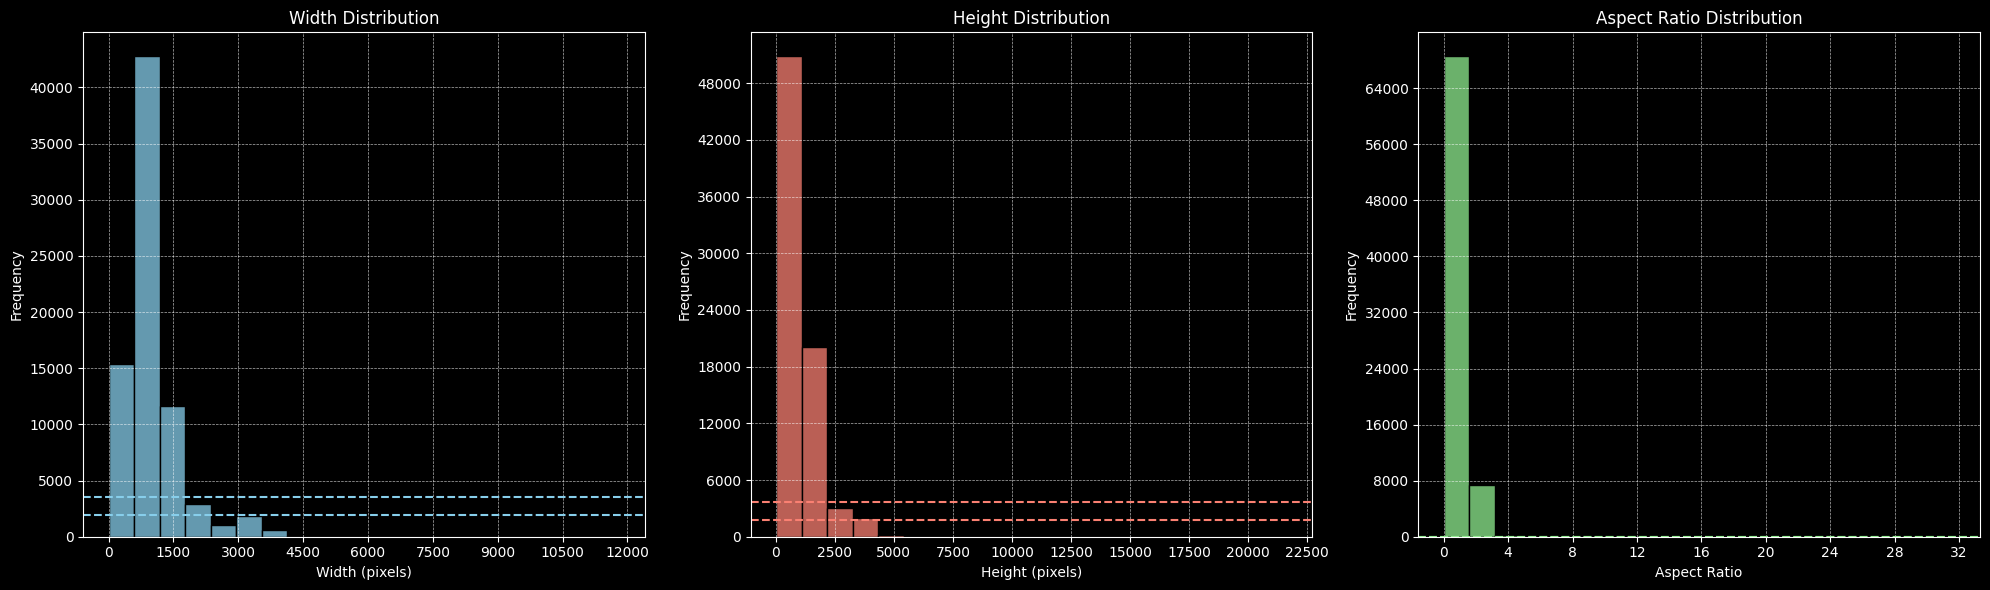

In [277]:
# Histograms
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Width Histogram
sns.histplot(
    data=df_raw["width"], ax=ax[0], bins=20, color="skyblue", edgecolor="black"
)
ax[0].set_title("Width Distribution")
ax[0].set_xlabel("Width (pixels)")
ax[0].set_ylabel("Frequency")

ax[0].xaxis.set_major_locator(MaxNLocator(nbins=10))
ax[0].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[0].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

ax[0].axhline(y=q1_width, color="skyblue", linestyle="--", label="3x Q1 (25th percentile)")
ax[0].axhline(y=q3_width, color="skyblue", linestyle="--", label="3x Q3 (75th percentile)")

# Height Histogram
sns.histplot(
    data=df_raw["height"], ax=ax[1], bins=20, color="salmon", edgecolor="black"
)
ax[1].set_title("Height Distribution")
ax[1].set_xlabel("Height (pixels)")
ax[1].set_ylabel("Frequency")

ax[1].xaxis.set_major_locator(MaxNLocator(nbins=10))
ax[1].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

ax[1].axhline(y=q1_height, color="salmon", linestyle="--", label="3x Q1 (25th percentile)")
ax[1].axhline(y=q3_height, color="salmon", linestyle="--", label="3x Q3 (75th percentile)")

# Aspect Ratio Histogram
sns.histplot(
    data=df_raw["aspect_ratio"],
    ax=ax[2],
    bins=20,
    color="lightgreen",
    edgecolor="black",
    )
ax[2].set_title("Aspect Ratio Distribution")
ax[2].set_xlabel("Aspect Ratio")
ax[2].set_ylabel("Frequency")

ax[2].xaxis.set_major_locator(MaxNLocator(nbins=10))
ax[2].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[2].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

ax[2].axhline(y=q1_aspect, color="lightgreen", linestyle="--", label="3x Q1 (25th percentile)")
ax[2].axhline(y=q3_aspect, color="lightgreen", linestyle="--", label="3x Q3 (75th percentile)")

plt.tight_layout()
plt.show()

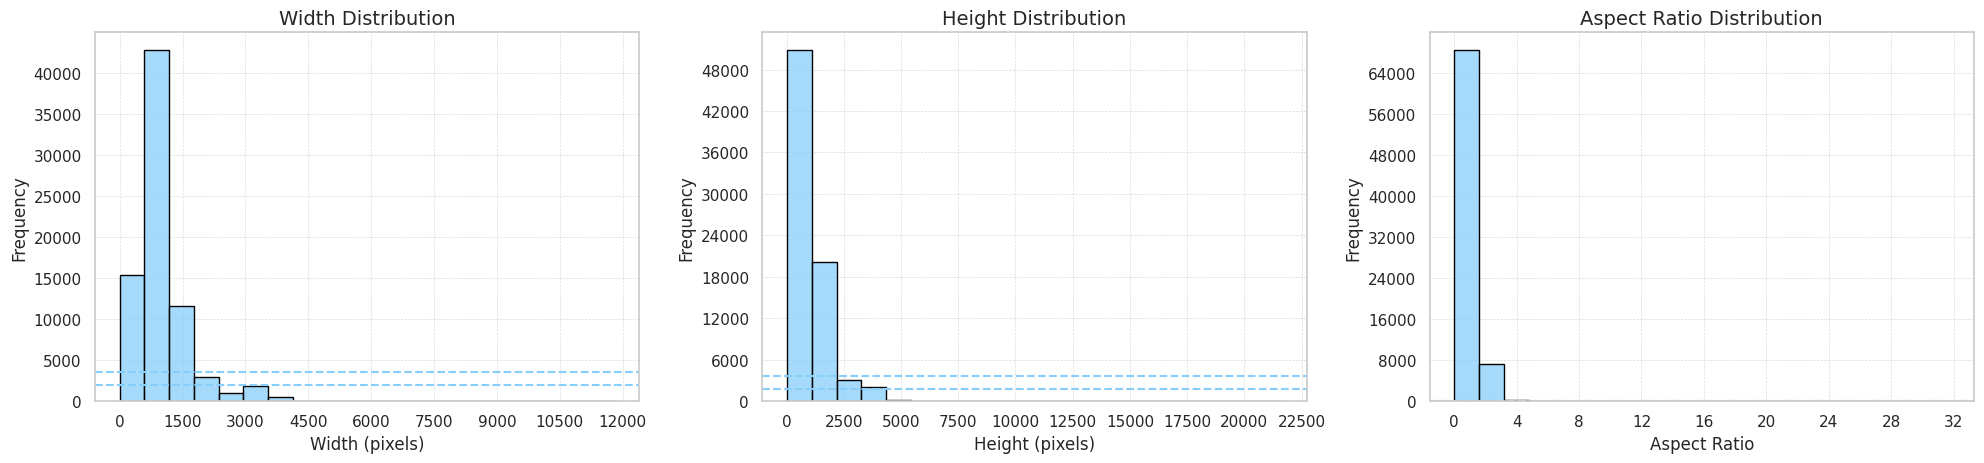

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams
from matplotlib import font_manager
font_manager.fontManager.addfont('/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf')

rcParams['font.family'] = 'Times New Roman'
# Set the theme to light mode
sns.set_theme(style="whitegrid")

q1_width, q3_width = df_raw["width"].quantile([0.25, 0.75]) * 3
q1_height, q3_height = df_raw["height"].quantile([0.25, 0.75]) * 3
q1_aspect, q3_aspect = df_raw["aspect_ratio"].quantile([0.25, 0.75]) * 3

# Create the subplots
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Width Histogram
sns.histplot(
    data=df_raw["width"], ax=ax[0], bins=20, color="lightskyblue", edgecolor="black"
)
ax[0].set_title("Width Distribution", fontsize=14)
ax[0].set_xlabel("Width (pixels)", fontsize=12)
ax[0].set_ylabel("Frequency", fontsize=12)

ax[0].xaxis.set_major_locator(MaxNLocator(nbins=10))
ax[0].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[0].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

ax[0].axhline(y=q1_width, color="lightskyblue", linestyle="--", label="3x Q1 (25th percentile)")
ax[0].axhline(y=q3_width, color="lightskyblue", linestyle="--", label="3x Q3 (75th percentile)")

# Height Histogram
sns.histplot(
    data=df_raw["height"], ax=ax[1], bins=20, color="lightskyblue", edgecolor="black"
)
ax[1].set_title("Height Distribution", fontsize=14)
ax[1].set_xlabel("Height (pixels)", fontsize=12)
ax[1].set_ylabel("Frequency", fontsize=12)

ax[1].xaxis.set_major_locator(MaxNLocator(nbins=10))
ax[1].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

ax[1].axhline(y=q1_height, color="lightskyblue", linestyle="--", label="3x Q1 (25th percentile)")
ax[1].axhline(y=q3_height, color="lightskyblue", linestyle="--", label="3x Q3 (75th percentile)")

# Aspect Ratio Histogram
sns.histplot(
    data=df_raw["aspect_ratio"],
    ax=ax[2],
    bins=20,
    color="lightskyblue",
    edgecolor="black",
)
ax[2].set_title("Aspect Ratio Distribution", fontsize=14)
ax[2].set_xlabel("Aspect Ratio", fontsize=12)
ax[2].set_ylabel("Frequency", fontsize=12)

ax[2].xaxis.set_major_locator(MaxNLocator(nbins=10))
ax[2].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[2].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

ax[2].axhline(y=q1_aspect, color="lightskyblue", linestyle="--", label="3x Q1 (25th percentile)")
ax[2].axhline(y=q3_aspect, color="lightskyblue", linestyle="--", label="3x Q3 (75th percentile)")


# Tight layout for better spacing
plt.tight_layout(rect=[0, 0.2, 1, 1])  # Leave space for the legend
plt.show()

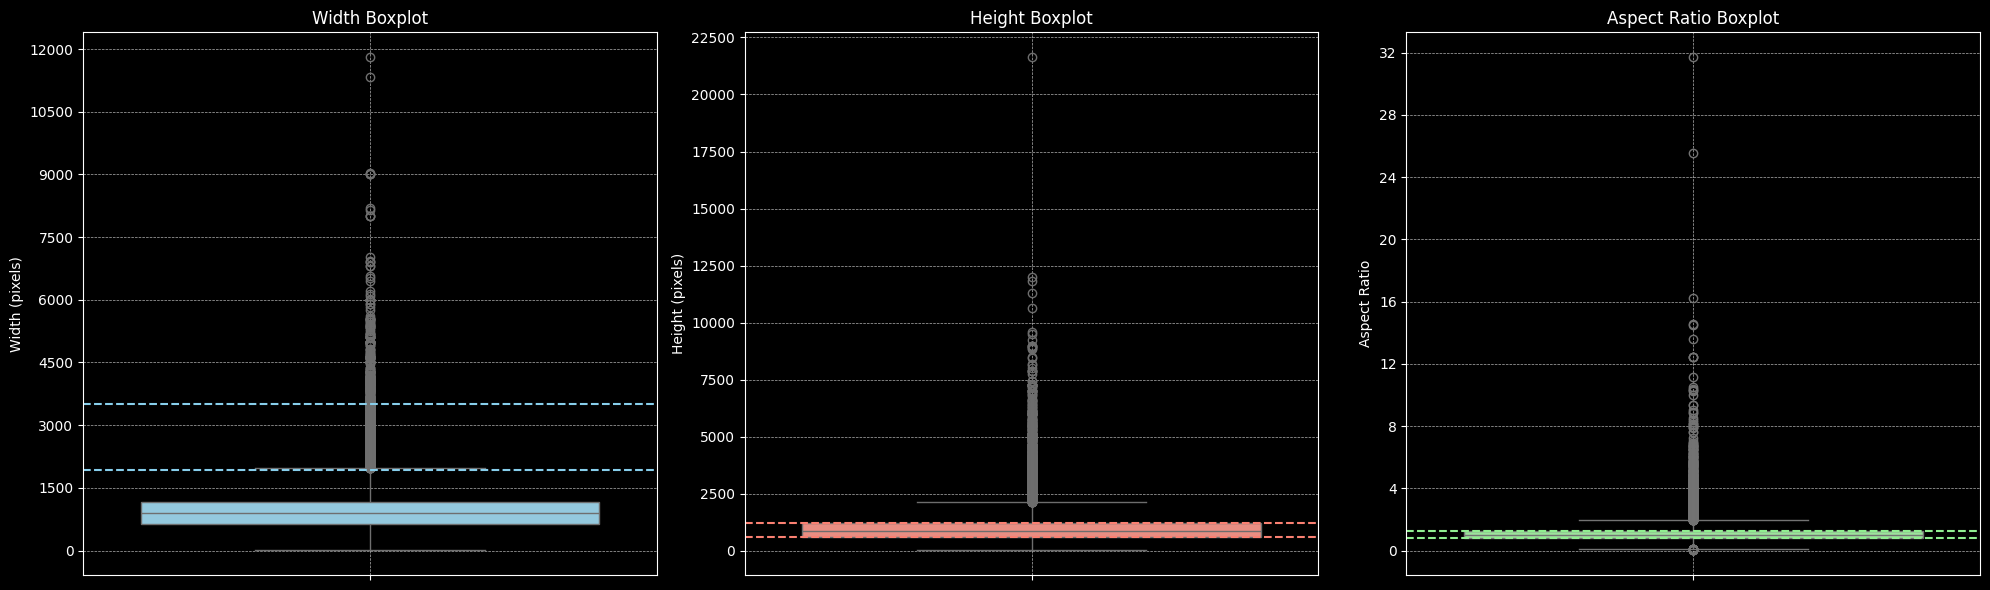

In [26]:
# Boxplots
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Width Boxplot
sns.boxplot(data=df_raw["width"], ax=ax[0], color="skyblue")

ax[0].set_title("Width Boxplot")
ax[0].set_ylabel("Width (pixels)")

ax[0].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[0].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

ax[0].axhline(y=q1_width, color="skyblue", linestyle="--", label="3x Q1 (25th percentile)")
ax[0].axhline(y=q3_width, color="skyblue", linestyle="--", label="3x Q3 (75th percentile)")

# Height Boxplot
sns.boxplot(data=df_raw["height"], ax=ax[1], color="salmon")

ax[1].set_title("Height Boxplot")
ax[1].set_ylabel("Height (pixels)")

ax[1].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

ax[1].axhline(y=q1_height, color="salmon", linestyle="--", label="3x Q1 (25th percentile)")
ax[1].axhline(y=q3_height, color="salmon", linestyle="--", label="3x Q3 (75th percentile)")

# Aspect Ratio Boxplot
sns.boxplot(data=df_raw["aspect_ratio"], ax=ax[2], color="lightgreen")

ax[2].set_title("Aspect Ratio Boxplot")
ax[2].set_ylabel("Aspect Ratio")

ax[2].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[2].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

ax[2].axhline(y=q1_aspect, color="lightgreen", linestyle="--", label="3x Q1 (25th percentile)")
ax[2].axhline(y=q3_aspect, color="lightgreen", linestyle="--", label="3x Q3 (75th percentile)")

plt.tight_layout()
plt.show()

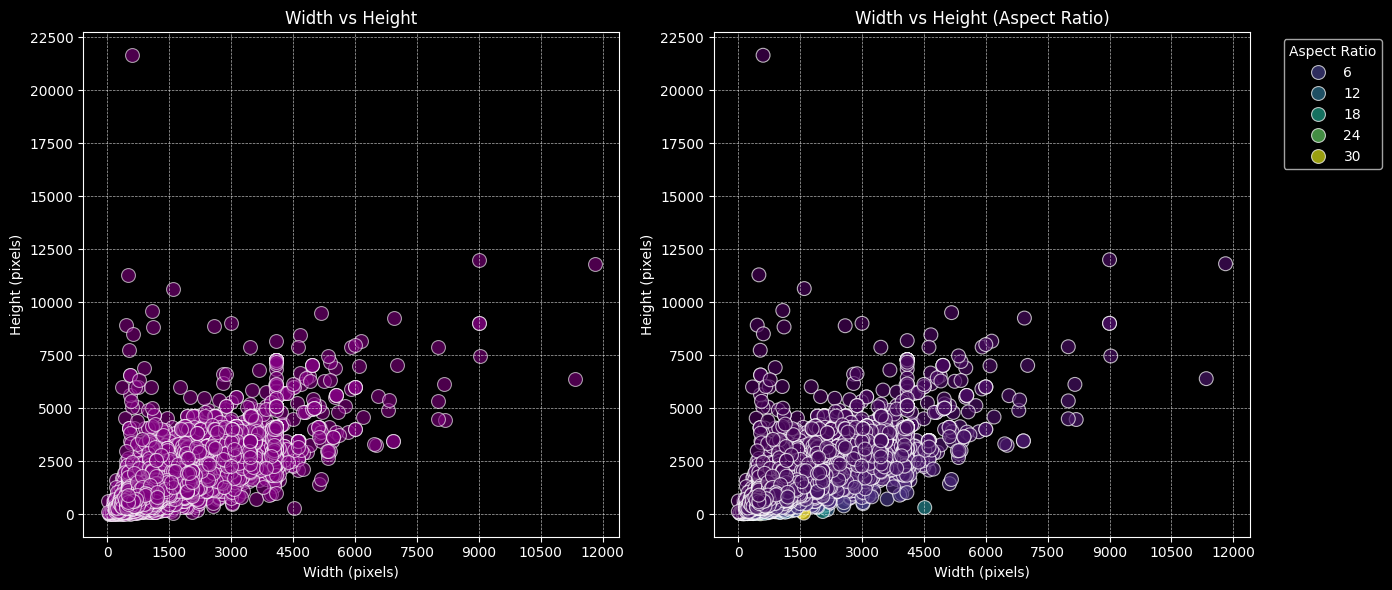

In [27]:
# Scatter plots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Scatter Plot without Hue
scatter1 = sns.scatterplot(
    data=df_raw,
    x="width",
    y="height",
    ax=ax[0],
    color="purple",
    alpha=0.6,
    edgecolor="w",
    s=100,
)
ax[0].set_title("Width vs Height")
ax[0].set_xlabel("Width (pixels)")
ax[0].set_ylabel("Height (pixels)")
ax[0].xaxis.set_major_locator(MaxNLocator(nbins=10))
ax[0].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[0].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Scatter Plot with Hue (Aspect Ratio)
scatter2 = sns.scatterplot(
    data=df_raw,
    x="width",
    y="height",
    hue="aspect_ratio",
    palette="viridis",
    ax=ax[1],
    alpha=0.7,
    edgecolor="w",
    s=100,
)
ax[1].set_title("Width vs Height (Aspect Ratio)")
ax[1].set_xlabel("Width (pixels)")
ax[1].set_ylabel("Height (pixels)")
ax[1].xaxis.set_major_locator(MaxNLocator(nbins=10))
ax[1].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Adjust legend for the second plot
if "aspect_ratio" in df_raw.columns:
    ax[1].legend(
        title="Aspect Ratio", bbox_to_anchor=(1.05, 1), loc="upper left"
    )

plt.tight_layout()
plt.show()

#### Without Outliers

In [18]:
df_filtered = utils.remove_outliers_iqr(
    df_raw, ["width", "height", "aspect_ratio"], 3
)
display(df_filtered)

2024-12-16 19:13:10,923 - root - INFO - Removed 2845 outliers from width
2024-12-16 19:13:10,943 - root - INFO - Removed 697 outliers from height
2024-12-16 19:13:10,961 - root - INFO - Removed 547 outliers from aspect_ratio


,id,author,created_utc,title,selftext,score,subreddit_subscribers,num_comments,total_awards_received,permalink,url,width,height,aspect_ratio
0,15v9uaw,neerajanchan,1692431595,It looks like….umm never mind!,NaN,1,27059555,25,0,/r/memes/comments/15v9uaw/it_looks_likeumm_nev...,https://i.redd.it/4ob2kkv1w0jb1.jpg,720.0,813.0,0.885609
1,164cv6s,1minuteryan,1693298652,Name a country not on the list without using G...,NaN,1,27229214,60,0,/r/memes/comments/164cv6s/name_a_country_not_o...,https://i.redd.it/hy6kljp3i0lb1.jpg,577.0,432.0,1.335648
2,15pdqiu,mortsGB,1691869730,Slinkies never went down the stairs when i use...,NaN,1,26948045,18,0,/r/memes/comments/15pdqiu/slinkies_never_went_...,https://i.redd.it/4btd9hbchqhb1.jpg,1080.0,1038.0,1.040462
3,160tlkj,FeelingDesigner,1692953564,How the hell is the French Bulldog now the mos...,NaN,1,27165388,481,0,/r/memes/comments/160tlkj/how_the_hell_is_the_...,https://i.redd.it/6ikffdf3z7kb1.png,997.0,1001.0,0.996004
4,15r4mcb,oranke_dino,1692041744,Allegedly.,NaN,1,26979939,27,0,/r/memes/comments/15r4mcb/allegedly/,https://i.redd.it/wn3pkeoto4ib1.jpg,960.0,1149.0,0.835509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76276,10caao4,davidmcdavidsonson,1673756339,Sad but true,NaN,0,24196464,8,0,/r/memes/comments/10caao4/sad_but_true/,https://i.redd.it/x1pbxvhxc6ca1.jpg,1200.0,810.0,1.481481
76277,10a6qv1,huge_throbbing_pp,1673548096,I just don’t get it.,NaN,0,24196926,13,0,/r/memes/comments/10a6qv1/i_just_dont_get_it/,https://i.redd.it/540o0djynnba1.jpg,509.0,499.0,1.020040
76278,100byxg,Still-Anxiety-8261,1672547945,But for real,NaN,0,23513333,8,0,/r/memes/comments/100byxg/but_for_real/,https://i.redd.it/dqew603rje9a1.jpg,620.0,607.0,1.021417
76279,107b8hh,superbloggity,1673260548,Freud peed sittiing down,NaN,0,24197615,14,0,/r/memes/comments/107b8hh/freud_peed_sittiing_...,https://i.redd.it/c6vmotwvwzaa1.jpg,500.0,585.0,0.854701


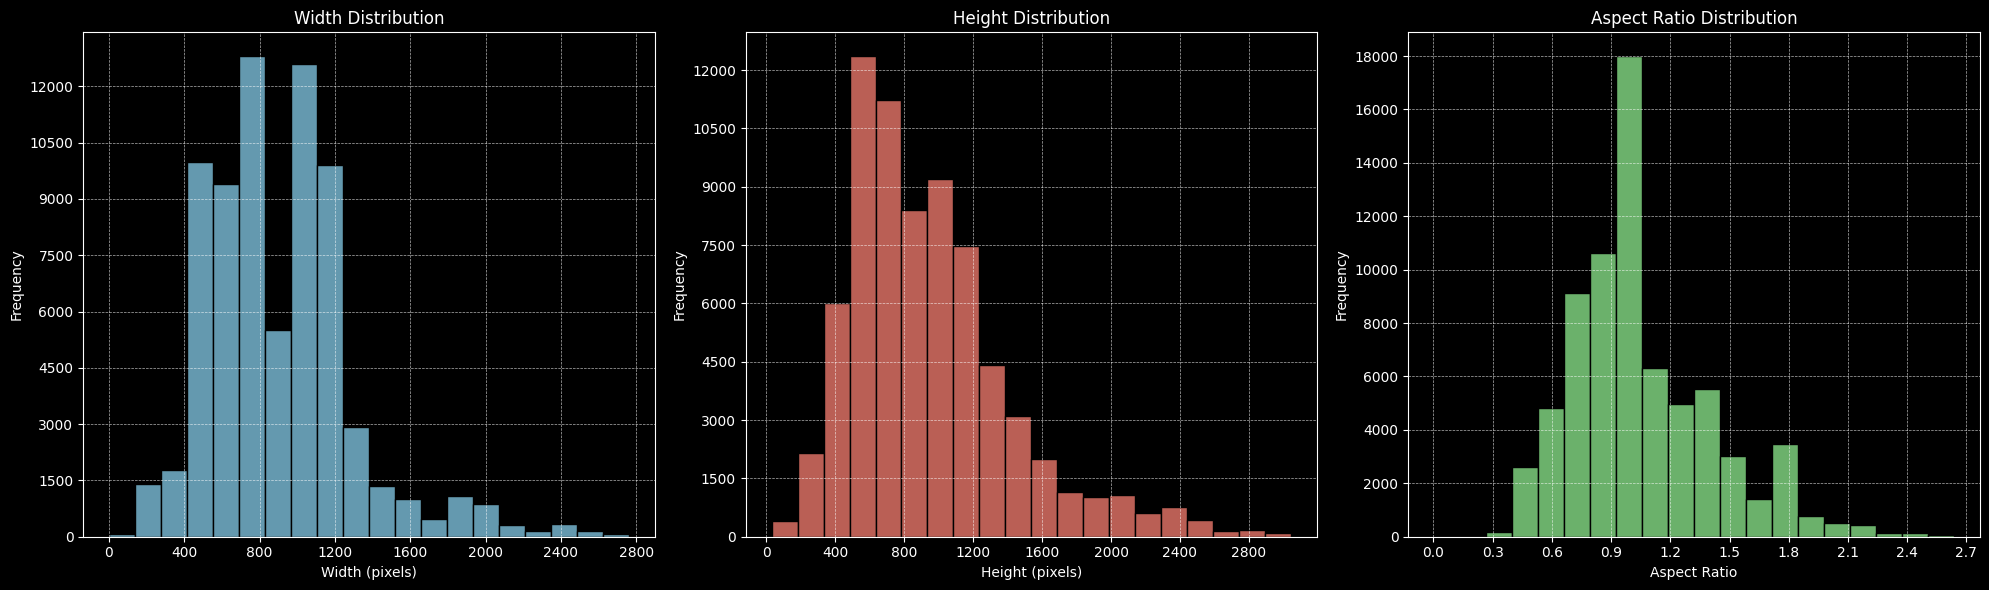

In [29]:
# Histograms
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Width Histogram
sns.histplot(
    data=df_filtered["width"],
    ax=ax[0],
    bins=20,
    color="skyblue",
    edgecolor="black",
)
ax[0].set_title("Width Distribution")
ax[0].set_xlabel("Width (pixels)")
ax[0].set_ylabel("Frequency")
ax[0].xaxis.set_major_locator(MaxNLocator(nbins=10))
ax[0].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[0].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Height Histogram
sns.histplot(
    data=df_filtered["height"],
    ax=ax[1],
    bins=20,
    color="salmon",
    edgecolor="black",
)
ax[1].set_title("Height Distribution")
ax[1].set_xlabel("Height (pixels)")
ax[1].set_ylabel("Frequency")
ax[1].xaxis.set_major_locator(MaxNLocator(nbins=10))
ax[1].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Aspect Ratio Histogram
sns.histplot(
    data=df_filtered["aspect_ratio"],
    ax=ax[2],
    bins=20,
    color="lightgreen",
    edgecolor="black",
)
ax[2].set_title("Aspect Ratio Distribution")
ax[2].set_xlabel("Aspect Ratio")
ax[2].set_ylabel("Frequency")
ax[2].xaxis.set_major_locator(MaxNLocator(nbins=10))
ax[2].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[2].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

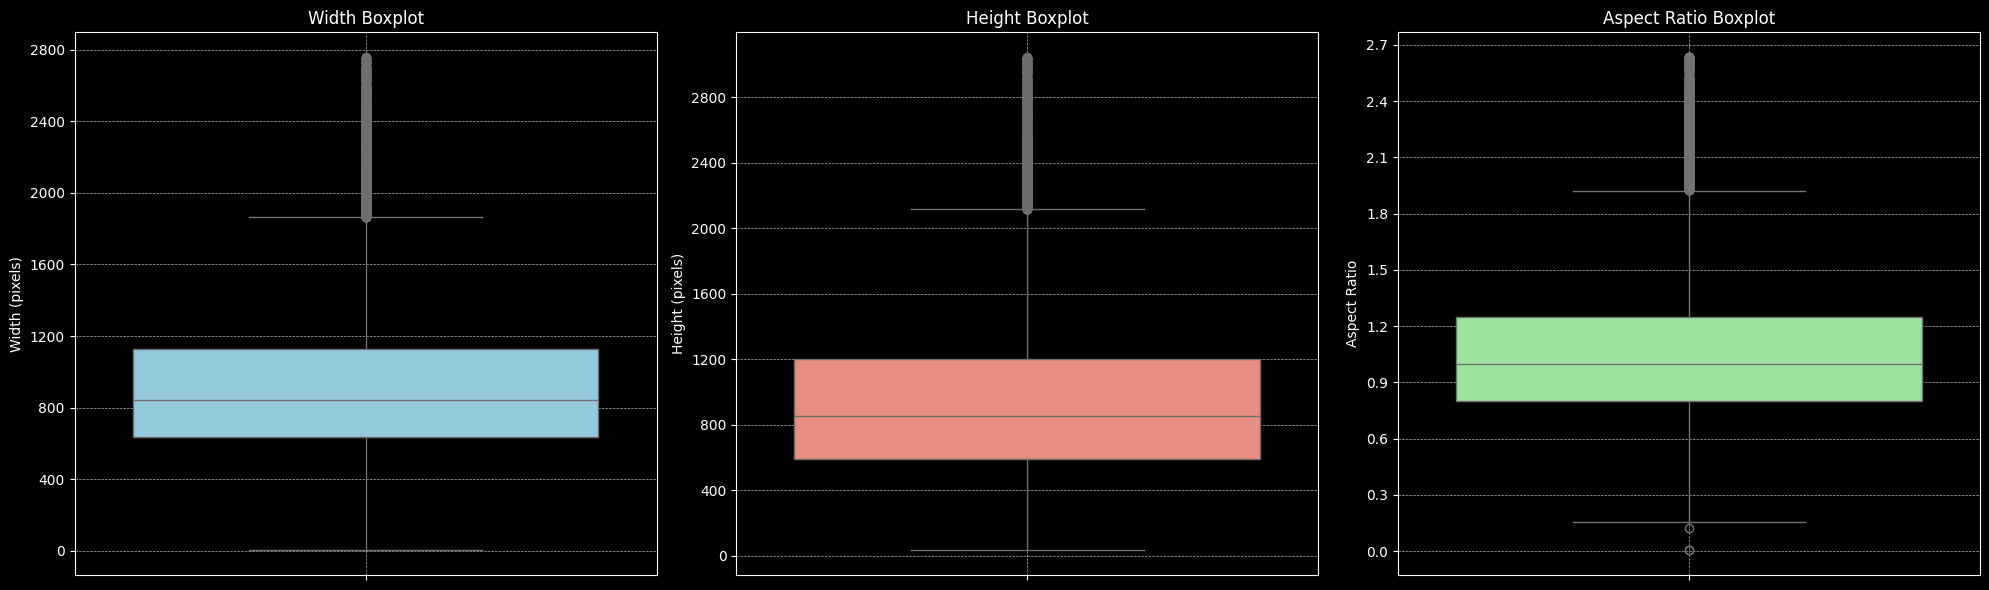

In [30]:
# Boxplots
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Width Boxplot
sns.boxplot(data=df_filtered["width"], ax=ax[0], color="skyblue")
ax[0].set_title("Width Boxplot")
ax[0].set_ylabel("Width (pixels)")
ax[0].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[0].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Height Boxplot
sns.boxplot(data=df_filtered["height"], ax=ax[1], color="salmon")
ax[1].set_title("Height Boxplot")
ax[1].set_ylabel("Height (pixels)")
ax[1].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Aspect Ratio Boxplot
sns.boxplot(data=df_filtered["aspect_ratio"], ax=ax[2], color="lightgreen")
ax[2].set_title("Aspect Ratio Boxplot")
ax[2].set_ylabel("Aspect Ratio")
ax[2].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[2].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

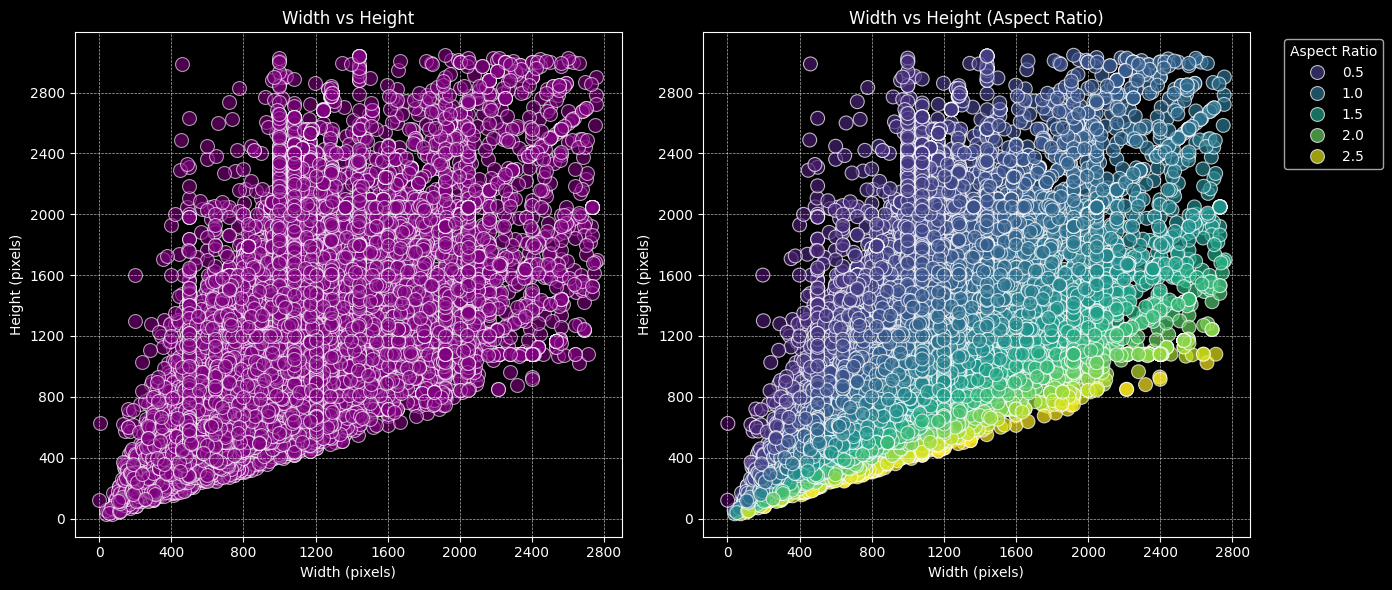

In [31]:
# Scatter plots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Scatter Plot without Hue
scatter1 = sns.scatterplot(
    data=df_filtered,
    x="width",
    y="height",
    ax=ax[0],
    color="purple",
    alpha=0.6,
    edgecolor="w",
    s=100,
)
ax[0].set_title("Width vs Height")
ax[0].set_xlabel("Width (pixels)")
ax[0].set_ylabel("Height (pixels)")
ax[0].xaxis.set_major_locator(MaxNLocator(nbins=10))
ax[0].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[0].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Scatter Plot with Hue (Aspect Ratio)
scatter2 = sns.scatterplot(
    data=df_filtered,
    x="width",
    y="height",
    hue="aspect_ratio",
    palette="viridis",
    ax=ax[1],
    alpha=0.7,
    edgecolor="w",
    s=100,
)
ax[1].set_title("Width vs Height (Aspect Ratio)")
ax[1].set_xlabel("Width (pixels)")
ax[1].set_ylabel("Height (pixels)")
ax[1].xaxis.set_major_locator(MaxNLocator(nbins=10))
ax[1].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Adjust legend for the second plot
if "aspect_ratio" in df_filtered.columns:
    ax[1].legend(
        title="Aspect Ratio", bbox_to_anchor=(1.05, 1), loc="upper left"
    )

plt.tight_layout()
plt.show()

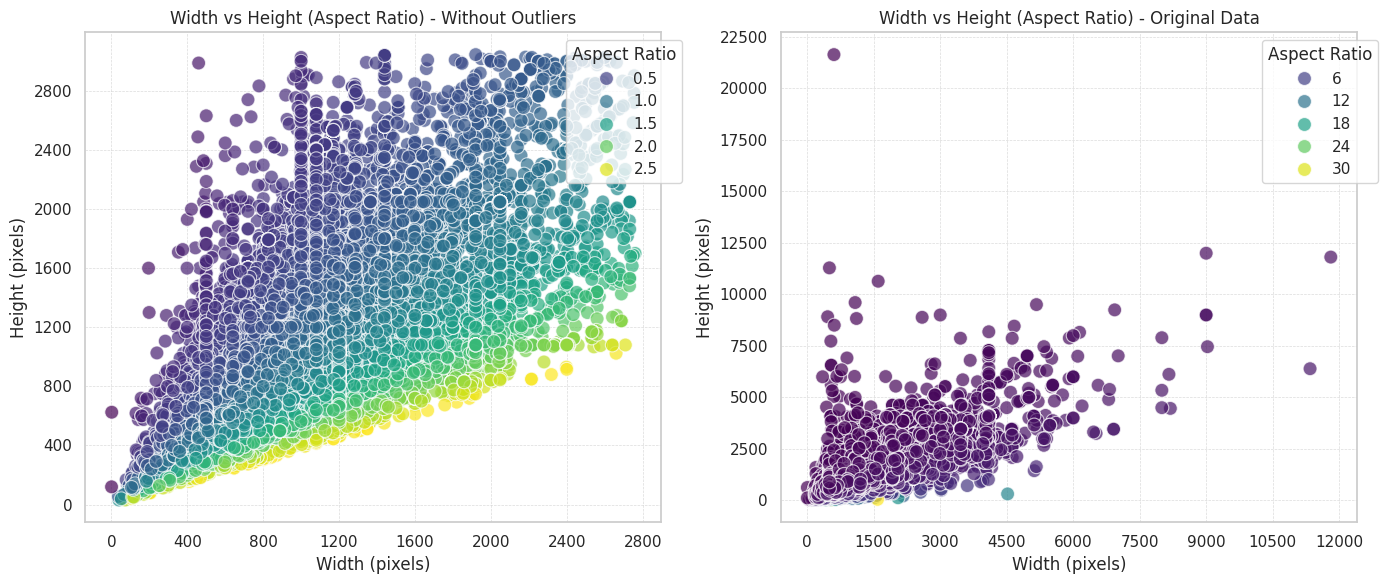

In [25]:
# Scatter plots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Scatter Plot with Hue (Aspect Ratio)
scatter1 = sns.scatterplot(
    data=df_filtered,
    x="width",
    y="height",
    hue="aspect_ratio",
    palette="viridis",
    ax=ax[0],
    alpha=0.7,
    edgecolor="w",
    s=100,
)
ax[0].set_title("Width vs Height (Aspect Ratio) - Without Outliers")
ax[0].set_xlabel("Width (pixels)")
ax[0].set_ylabel("Height (pixels)")
ax[0].xaxis.set_major_locator(MaxNLocator(nbins=10))
ax[0].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[0].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Adjust legend for the second plot
if "aspect_ratio" in df_filtered.columns:
    ax[0].legend(
        title="Aspect Ratio", bbox_to_anchor=(1.05, 1), loc="upper right"
    )


# Scatter Plot with Hue (Aspect Ratio)
scatter2 = sns.scatterplot(
    data=df_raw,
    x="width",
    y="height",
    hue="aspect_ratio",
    palette="viridis",
    ax=ax[1],
    alpha=0.7,
    edgecolor="w",
    s=100,
)
ax[1].set_title("Width vs Height (Aspect Ratio) - Original Data")
ax[1].set_xlabel("Width (pixels)")
ax[1].set_ylabel("Height (pixels)")
ax[1].xaxis.set_major_locator(MaxNLocator(nbins=10))
ax[1].yaxis.set_major_locator(MaxNLocator(nbins=10))
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Adjust legend for the second plot
if "aspect_ratio" in df_raw.columns:
    ax[1].legend(
        title="Aspect Ratio", bbox_to_anchor=(1.05, 1), loc="upper right"
    )

plt.tight_layout()
plt.show()

#### Outlier Specific Analysis

In [282]:
df_outliers = df_raw[~df_raw.index.isin(df_filtered.index)]
display(df_outliers)

,id,author,created_utc,title,selftext,score,subreddit_subscribers,num_comments,total_awards_received,permalink,url,width,height,aspect_ratio
65,165gr0j,schnudifudi,1693406811,if you have both you’re prolly a unicorn (with...,NaN,1,27249437,64,0,/r/memes/comments/165gr0j/if_you_have_both_you...,https://i.redd.it/rbhv3d4uf9lb1.jpg,3464.0,3464.0,1.000000
127,161970m,Ok-Construction6245,1692992911,Meme i made about myself,NaN,1,27175998,67,0,/r/memes/comments/161970m/meme_i_made_about_my...,https://i.redd.it/8fbk06r49bkb1.jpg,2880.0,4320.0,0.666667
205,161cv2v,PMBHero,1693001429,How many seasons do you think it’ll last?,NaN,1,27176078,91,0,/r/memes/comments/161cv2v/how_many_seasons_do_...,https://i.redd.it/7196rejgybkb1.jpg,3253.0,2990.0,1.087960
239,15mes71,KaptainMurica96,1691586319,LIARRRR!!!,NaN,1,26900334,75,0,/r/memes/comments/15mes71/liarrrr/,https://i.redd.it/0l30bctl23hb1.jpg,4096.0,3072.0,1.333333
266,1606y92,Massimo25ore,1692894999,The real truth,NaN,1,27153697,241,0,/r/memes/comments/1606y92/the_real_truth/,https://i.redd.it/79ppxnfz53kb1.jpg,2880.0,2880.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76174,17ntt49,Waluigithefake1,1699127522,I just don't understand it,NaN,176,28270420,7,0,/r/memes/comments/17ntt49/i_just_dont_understa...,https://i.redd.it/g7d8nfahydyb1.jpg,3961.0,2752.0,1.439317
76211,10nd2a1,[deleted],1674905604,Judaism Is the Most Pedophile-Friendly Ideolog...,NaN,0,24193480,11,0,/r/memes/comments/10nd2a1/judaism_is_the_most_...,https://i.imgflip.com/7938su.jpg,929.0,318.0,2.921384
76214,108odcv,Lucario2356,1673392530,Rate my countries tier list 😀,NaN,0,24197274,11,0,/r/memes/comments/108odcv/rate_my_countries_ti...,https://i.redd.it/6qs8yipjtaba1.png,1140.0,4250.0,0.268235
76246,108v1qr,brainharmer,1673410148,(image unrelated) I SWEAR TO GOD im making a r...,NaN,0,24197229,13,0,/r/memes/comments/108v1qr/image_unrelated_i_sw...,https://i.redd.it/ehk699ty9cba1.jpg,3840.0,2160.0,1.777778


#### Outlier Examples

##### Width

In [40]:
# Examples of width outliers
df_outliers.sort_values(by="width", ascending=False).head()

for _index, row in df_outliers.sort_values(by="width", ascending=False).head().iterrows():
    image = Image.open(f"{image_dir}/{row['id']}.jpeg")
    image.save(f"outlier_examples/width/{row['id']}.jpeg")

In [53]:
displayed_list_width = []

In [ ]:
print("*" * 150)
print("Width Outlier Example")
random_choice = random.choice([path for path in os.listdir("outlier_examples/width") if path not in displayed_list_width])
display(Image.open(f"outlier_examples/width/{random_choice}"))
displayed_list_width += [random_choice]

##### Height

In [ ]:
# Examples of height outliers
df_outliers.sort_values(by="height", ascending=False).head()

for _index, row in df_outliers.sort_values(by="height", ascending=False).head().iterrows():
    image = Image.open(f"{image_dir}/{row['id']}.jpeg")
    image.save(f"outlier_examples/height/{row['id']}.jpeg")

In [50]:
displayed_list_height = []

In [ ]:
print("*" * 150)
print("Height Outlier Example")
random_choice = random.choice([path for path in os.listdir("outlier_examples/height") if path not in displayed_list_height])
display(Image.open(f"outlier_examples/height/{random_choice}"))
displayed_list_height += [random_choice]

##### Aspect Ratio

In [ ]:
# Examples of aspect ratio outliers
df_outliers.sort_values(by="aspect_ratio", ascending=False).head()

for _index, row in df_outliers.sort_values(by="aspect_ratio", ascending=False).head(50).iterrows():
    image = Image.open(f"{image_dir}/{row['id']}.jpeg")
    image.save(f"outlier_examples/aspect_ratio/{row['id']}.jpeg")

In [284]:
displayed_list_ar = []

In [ ]:
print("*" * 150)
print("Aspect Ratio Outlier Example")
random_choice = random.choice([path for path in os.listdir("outlier_examples/aspect_ratio") if path not in displayed_list_ar])
display(Image.open(f"outlier_examples/aspect_ratio/{random_choice}"))
displayed_list_ar += [random_choice]

### Formatting Images
#### Announced Input Constraints:
 * LLaVA 1.6 - 672x672, 336x1344, 1344x336 resolutions.
 * llava-llama3 - 336
 * llava-phi3 - 336
 * Qwen2-VL-7B-Instruct - arbitrary resolution

In [ ]:
# Clean memory
del df_raw, _index, row, image, image_dir, fig, ax, file, \
    q1_aspect, q1_height, q1_width, q3_aspect, q3_height, \
    q3_width, scatter1, scatter2

In [ ]:
base_path = "../Data Collection Functions/downloaded_images/sample"
output_path = "./resized_sample"

utils.resize_images(base_path, (336, 336), output_path)

In [ ]:
base_path = "outlier_examples/width"
output_path = "resized_outliers/width"
utils.resize_images(base_path, (336, 336), output_path)

base_path = "outlier_examples/height"
output_path = "resized_outliers/height"
utils.resize_images(base_path, (336, 336), output_path)

base_path = "outlier_examples/aspect_ratio"
output_path = "resized_outliers/aspect_ratio"
utils.resize_images(base_path, (336, 336), output_path)

In [4]:
displayed_list_width = []
displayed_list_height = []
displayed_list_ar = []

In [ ]:
print("*" * 150)
print("Formatted Width Outlier Example")
random_choice = random.choice([path for path in os.listdir("resized_outliers/width") if path not in displayed_list_width])
display(Image.open(f"resized_outliers/width/{random_choice}"))
print("VS Original Width Outlier")
display(Image.open(f"outlier_examples/width/{random_choice}"))
displayed_list_width += [random_choice]

In [ ]:
print("*" * 150)
print("Formatted Height Outlier Example")
random_choice = random.choice([path for path in os.listdir("resized_outliers/height") if path not in displayed_list_height])
display(Image.open(f"resized_outliers/height/{random_choice}"))
print("VS Original Height Outlier")
display(Image.open(f"outlier_examples/height/{random_choice}"))
displayed_list_height += [random_choice]

In [ ]:
print("*" * 150)
print("Formatted Aspect Ratio Outlier Example")
random_choice = random.choice([path for path in os.listdir("resized_outliers/aspect_ratio") if path not in displayed_list_ar])
display(Image.open(f"resized_outliers/aspect_ratio/{random_choice}"))
print("VS Original Aspect Ratio Outlier")
display(Image.open(f"outlier_examples/aspect_ratio/{random_choice}"))
displayed_list_ar += [random_choice]

---
## Experimenting with Models

In [92]:
ollama.list()

2024-11-24 21:45:02,874 - httpx - INFO - HTTP Request: GET http://127.0.0.1:11434/api/tags "HTTP/1.1 200 OK"


{'models': [{'name': 'llama3.2-vision:11b',
   'model': 'llama3.2-vision:11b',
   'modified_at': '2024-11-24T19:28:55.333107916Z',
   'size': 7901829417,
   'digest': '38107a0cd11910a31c300fcfd1e9a107b2928e56ebabd14598702170b004773e',
   'details': {'parent_model': '',
    'format': 'gguf',
    'family': 'mllama',
    'families': ['mllama', 'mllama'],
    'parameter_size': '9.8B',
    'quantization_level': 'Q4_K_M'}},
  {'name': 'bakllava:latest',
   'model': 'bakllava:latest',
   'modified_at': '2024-11-24T19:28:54.730107916Z',
   'size': 4733351307,
   'digest': '3dd68bd4447cba20e20deba918749e7f58ff689a8ba4a90c9ff9dc9118037486',
   'details': {'parent_model': '',
    'format': 'gguf',
    'family': 'llama',
    'families': ['llama', 'clip'],
    'parameter_size': '7B',
    'quantization_level': 'Q4_0'}},
  {'name': 'minicpm-v:latest',
   'model': 'minicpm-v:latest',
   'modified_at': '2024-11-24T19:28:54.127107916Z',
   'size': 5473838466,
   'digest': 'c92bfad0120556eda311984f1ac2f0

### Ollama Syntax

In [10]:
sample_path = "../Data Collection Functions/downloaded_images/sample"

In [ ]:
image_path = os.path.join(sample_path, "10aj7gr.jpeg")
res = ollama.chat(
    model="llava-llama3:latest",
    messages=[
        {
            "role": "user",
            "content": "How would you categorize this meme, between the categories of Macros, Stacked Stills, Comics or IRL memes",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-24 21:45:52,036 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
This is an IRL (In Real Life) meme. It consists of a series of four images arranged in a 2x2 grid on a white background. 

Starting from the top left corner, there's a black and white cartoon drawing of a woman with long blonde hair. She appears to be standing and looking off into the distance. 

Adjacent to her, in the top right corner, is another black and white cartoon drawing. This one depicts a man wearing a hooded sweatshirt. He too seems to be standing and looking off into the distance.

The bottom row of images continues this pattern. In the bottom left corner, there's a third black and white cartoon drawing. This one shows a woman with short brown hair, who is sitting down and looking away from the viewer.

Finally, in the bottom right corner, there's another black and white cartoon drawing. This one depicts a man wearing a base

In [95]:
image_path = os.path.join(sample_path, "10aj7gr.jpeg")
res = ollama.chat(
    model="llava-llama3:latest",
    messages=[
        {
            "role": "user",
            "content": "How would you categorize this meme, between the categories of Macros, Stacked Stills, Comics or IRL memes",
            "images": [image_path],
        }
    ],
    options = {"temperature":0.5}
)
print("*" * 150)
print(res["message"]["content"])

2024-11-24 21:46:00,508 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
This is a meme that consists of three separate images arranged in a grid. The top left image features a cartoon illustration of a woman with blonde hair wearing a blue dress adorned with white polka dots. She appears to be in conversation with a man who is dressed in a black suit and hat.

The bottom left image presents a scene from the movie "The Dark Knight". Batman, portrayed by actor Christian Bale, is seen riding a motorcycle through a cityscape at night. Accompanying him is Rachel Dawes, who is also on a motorcycle.

Lastly, the bottom right image features an illustration of Batman's face with a beard and mustache. The text accompanying these images reads: "I can't believe he didn't cry during the Titanic! Does he even have feelings?" This suggests that the meme is humorously commenting on Batman's character from the movie "The Dar

In [14]:
image_path = os.path.join(sample_path, "10aj7gr.jpeg")
res = ollama.chat(
    model="llava-llama3:latest",
    messages=[
        {
            "role": "user",
            "content": "How would you categorize this meme, between the categories of Macros, Stacked Stills, Comics or IRL memes",
            "images": [image_path],
        }
    ],
    options = {"num_predict":1}
)
print("*" * 150)
print(res["message"]["content"])

2024-11-28 01:11:02,885 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
This


### Response Variability

In [15]:
message_test =("Please classify the following image into one of the following meme categories:"
               "1. Screenshots: Images capturing digital media, where content is non textual. E.g. image of video game or animated series;"
               "2. Text-Based Memes: Images only containing text. E.g. Walls of text, screenshots of tweets and messages;"
               "3. Photos / IRL Situations / Objects: Memes where the main focus is an organic real world image. Should not have alterations like text over the image or photoshop;"
               "4. Drawings / Illustrations / Photoshops: Artworks or edited images;"
               "5. Emotional Reactions: Memes that often have a text section on top and at the bottom a reaction that invokes an emotion through the expression. E.g. The Roll Safe Smart Reaction;"
               "6. Event Reactions: Similar to emotional, with text in the top, but the reaction is with a specific situation instead of a facial expression. E.g. A meme where the reaction is a skeleton exploding (an event) or a reaction with a line of a TV Series;"
               "7. Macros: Often single images with centered text in the top and/or bottom in Impact Font, very popular in older internet. E.g. Success Kid and Bad Luck Brian;"
               "8. Situational Memes: Image creates an absurd situation by overlaying text over elements of the image (often on top of objects or heads). E.g. An image of a person putting gasoline on fire, and three seperate texts over the gas tank, the fire pit and the person;"
               "9. Comics / Stacked Stills: Series of panels or images telling a story e.g. Two frames of a movie stacked on top of each other;"
               "10. Meme Characters: Memes featuring well-known characters (e.g., Wojak, Chad, Shrek, Troll Face and Rage Characters, Stonks Man and Pepe);"
               "11. Template: Image follows widely popular meme templates, like the expanding mind template, Mr. Incredible, Drake, Change my Mind, Distracted Boyfriend, This is Fine, People Raising Hands."
               "Answer with only one category.")

In [37]:
image_path = os.path.join(sample_path, "145578h.jpeg")
print("*" * 150)

for i in range(20):
    res = ollama.chat(
        model="llava:7b",
        messages=[
            {
                "role": "user",
                "content": message_test,
                "images": [image_path],
            }
        ],
    )
    print(res["message"]["content"])


******************************************************************************************************************************************************


2024-12-15 23:53:22,502 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-12-15 23:53:22,648 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


 2 
 2 


2024-12-15 23:53:22,797 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-12-15 23:53:22,939 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


 3 
 4 


2024-12-15 23:53:23,245 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-12-15 23:53:23,387 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


 9. Situational Memes 
 7 


2024-12-15 23:53:23,530 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-12-15 23:53:23,685 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


 5 
 6 


2024-12-15 23:53:23,829 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


 3 


2024-12-15 23:53:24,067 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-12-15 23:53:24,207 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


 Text-Based Memes 
 5 


2024-12-15 23:53:24,603 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-12-15 23:53:24,781 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


 Photos / IRL Situations / Objects 
 Event Reactions 


2024-12-15 23:53:25,181 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-12-15 23:53:25,336 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


 Photos / IRL Situations / Objects 
 3 


2024-12-15 23:53:26,494 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-12-15 23:53:26,641 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


 The image shows an organic real world situation involving a toy display and text meme. It falls under the Photos / IRL Situations / Objects category. 
 3 


2024-12-15 23:53:26,788 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-12-15 23:53:26,940 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


 2 
 3 


2024-12-15 23:53:27,382 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


 Photos / IRL Situations / Objects 


In [40]:
results = []
for i in range(20):
    result = inference.infer("llava:7b", message_test, image_path)
    result = inference.label_validator(result.get("label", "None"))
    results.append(result)

2024-12-15 23:54:00,619 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-12-15 23:54:00,754 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-12-15 23:54:00,889 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-12-15 23:54:01,029 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-12-15 23:54:01,301 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-12-15 23:54:01,439 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-12-15 23:54:01,579 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-12-15 23:54:01,719 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-12-15 23:54:01,985 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-12-15

In [42]:
value_counts = pd.DataFrame(results, columns=["Category"])["Category"].value_counts()
display(value_counts)

Category
photo                 5
drawing               3
event_reaction        3
none                  3
emotional_reaction    2
situational           2
macro                 1
comic                 1
Name: count, dtype: int64

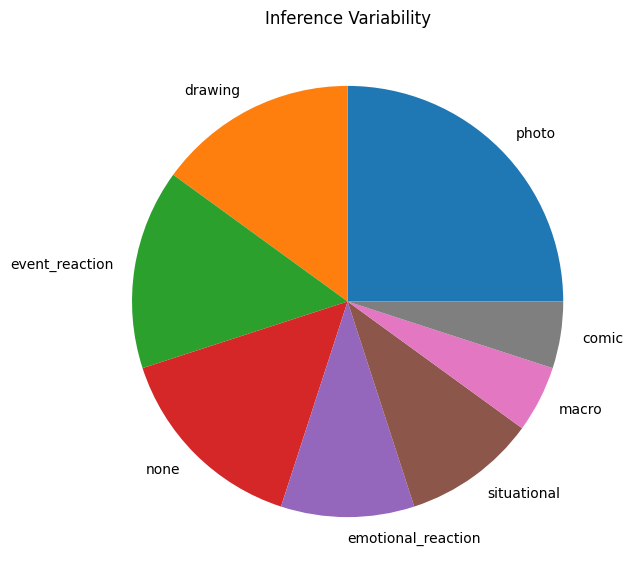

In [49]:
value_counts.plot(kind="pie", figsize=(7, 7), title="Inference Variability")
plt.ylabel("")
plt.show()

In [59]:
# Format index names

value_counts.index = ['Photo', 'Drawing', 'Event Reaction', 'None', 'Emotional Reaction', 'Situational', 'Macro', 'Comic']
value_counts

Photo                 5
Drawing               3
Event Reaction        3
None                  3
Emotional Reaction    2
Situational           2
Macro                 1
Comic                 1
Name: count, dtype: int64

Text(0, 0.5, '')

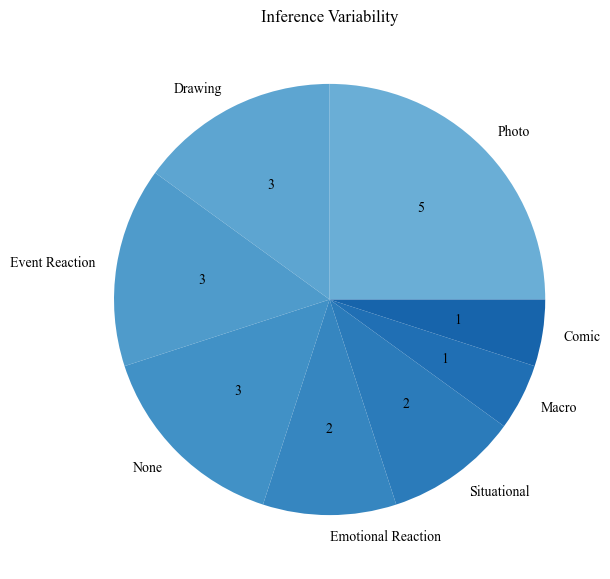

In [67]:
from matplotlib import rcParams
from matplotlib import font_manager
font_manager.fontManager.addfont('/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf')

rcParams['font.family'] = 'Times New Roman'
custom_colors = plt.cm.Blues(np.linspace(0.5, 0.8, len(value_counts)))


def absolute_value_func(pct, all_values):
    absolute = int(pct / 100 * sum(all_values))
    return f'{absolute}'  # Format as absolute value

value_counts.plot(
    kind="pie",
    figsize=(20, 7),
    colors=custom_colors,  # Apply custom color scheme
    autopct=lambda pct: absolute_value_func(pct, value_counts),  # Custom absolute value labels
    title="Inference Variability"  # Add the title
)

# Customize labels
plt.ylabel("")  # Remove the default ylabel


In [55]:
display(Image.open(image_path))

### Model Response to Outlier Images vs. Reformatted Outliers

In [71]:
outliers_path = "outlier_examples"
reformatted_path = "resized_outliers"
runs = 15

In [166]:
message_speed_test =("Please classify the following image into one of the following meme categories:"
               "1. Screenshots: Images capturing digital media, where content is non textual. E.g. image of video game or animated series;"
               "2. Text-Based Memes: Images only containing text. E.g. Walls of text, screenshots of tweets and messages;"
               "3. Photos / IRL Situations / Objects: Memes where the main focus is an organic real world image. Should not have alterations like text over the image or photoshop;"
               "4. Drawings / Illustrations / Photoshops: Artworks or edited images;"
               "5. Emotional Reactions: Memes that often have a text section on top and at the bottom a reaction that invokes an emotion through the expression. E.g. The Roll Safe Smart Reaction;"
               "6. Event Reactions: Similar to emotional, with text in the top, but the reaction is with a specific situation instead of a facial expression. E.g. A meme where the reaction is a skeleton exploding (an event) or a reaction with a line of a TV Series;"
               "7. Macros: Often single images with centered text in the top and/or bottom in Impact Font, very popular in older internet. E.g. Success Kid and Bad Luck Brian;"
               "8. Situational Memes: Image creates an absurd situation by overlaying text over elements of the image (often on top of objects or heads). E.g. An image of a person putting gasoline on fire, and three seperate texts over the gas tank, the fire pit and the person;"
               "9. Comics / Stacked Stills: Series of panels or images telling a story e.g. Two frames of a movie stacked on top of each other;"
               "10. Meme Characters: Memes featuring well-known characters (e.g., Wojak, Chad, Shrek, Troll Face and Rage Characters, Stonks Man and Pepe);"
               "11. Template: Image follows widely popular meme templates, like the expanding mind template, Mr. Incredible, Drake, Change my Mind, Distracted Boyfriend, This is Fine, People Raising Hands."
               "Answer with only one category.")

In [168]:
df_speeds_outliers = pd.DataFrame(columns=[
    "model", "runs", "width_raw", "width_resized", "width_delta", "height_raw",
    "height_resized", "height_delta", "aspect_raw", "aspect_resized", "aspect_delta"
])

#### Llava 1.6 7b (llava:7b)

In [13]:
model_name = "llava:7b"

In [170]:
times = {
    "model" : model_name,
    "runs" : runs,
    "width_raw" : None,
    "width_resized" : None,
    "width_delta" : None,
    "height_raw" : None,
    "height_resized" : None,
    "height_delta" : None,
    "aspect_raw" : None,
    "aspect_resized" : None,
    "aspect_delta" : None
}

##### Width

In [171]:
image_path = os.path.join(outliers_path, "width", "11va2md.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-24 23:20:43,939 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
 The meme depicts a humorous scenario where four cat memes are labeled as "My groupmates before reporting," suggesting that the individuals in the image are portraying their friends' behavior when they intend to report something, possibly for feedback or improvement. Each cat is anthropomorphized with a speech bubble containing text that adds to the comedic effect by mimicking human-like behavior and communication, often with a twist of absurdity or self-deprecation. The cats are arranged in two rows, each facing forward with one eye visible, giving them a playful, curious appearance.

The meme is likely meant for an online audience to relate to common behaviors among friends or acquaintances when it comes to sharing concerns or issues about something they're involved in. It uses the internet cat meme format to convey a humorous take on 

In [ ]:
display(Image.open(image_path))

In [173]:
runtimes_raw = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_raw.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["width_raw"] = sum(runtimes_raw) / len(runtimes_raw)

2024-11-24 23:20:49,438 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:20:49,850 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:20:50,106 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:20:50,559 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:20:50,915 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:20:51,287 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:20:51,637 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:20:51,969 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:20:52,375 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24

In [14]:
image_path = os.path.join(reformatted_path, "width", "11va2md.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-12-15 18:28:06,744 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
 The meme features a group of cartoon kittens sitting next to each other, with thought bubbles above their heads containing various messages. One of the kittens says, "Me and my groupmates before reporting," indicating that the image is meant to represent what people might think or say before they submit something for review or scrutiny. The text and images are likely intended to be humorous, poking fun at common behaviors or thoughts related to reporting or sharing information with someone else, possibly a boss, teacher, or another authority figure. 


In [ ]:
display(Image.open(image_path))

In [176]:
runtimes_resized = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_resized.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["width_resized"] = sum(runtimes_resized) / len(runtimes_resized)

2024-11-24 23:21:08,196 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:08,638 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:08,832 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:09,034 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:09,197 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:09,510 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:09,848 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:10,116 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:10,461 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24

In [177]:
times["width_delta"] = f"{times["width_resized"] - times["width_raw"]}" +\
                       f" ({round((times["width_resized"] - times["width_raw"]) / times["width_raw"] * 100, 2)}%)"

In [178]:
image_path = os.path.join(outliers_path, "width", "13yren2.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-24 23:21:17,816 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
 The image you've provided appears to be a digital artwork or graphic design rather than a meme, which typically includes text and a humorous context. This image shows two rectangles with different shades of gray against a neutral background. The top rectangle is lighter in color, while the bottom rectangle is darker. There is no visible text on the image to provide additional context or to describe what is depicted beyond the simple geometric shapes. 


In [ ]:
display(Image.open(image_path))

In [47]:
image_path = os.path.join(reformatted_path, "width", "13yren2.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-12-15 19:22:06,343 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
 The image you've provided appears to be a blank canvas with no visible text or other content that would typically be associated with a meme. A meme is typically an image, often with text, that conveys humor through the use of recognizable elements from movies, TV shows, internet culture, and more. In this case, there's nothing to describe as it does not contain any elements of a meme. 


In [ ]:
display(Image.open(image_path))

##### Height

In [48]:
image_path = os.path.join(outliers_path, "height", "118rvkv.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-12-15 19:22:25,949 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
 The image appears to be a screenshot of a computer desktop with various windows open. There is a window with what looks like a web browser, showing a website with the word "NUTS" at the top and some content below it that's too small to read clearly. Another window on the right side shows a collection of images or thumbnails that are also too small to discern their content. There is a third window at the bottom left corner which seems to contain a spreadsheet with data in cells, but the image resolution makes it difficult to distinguish details.

The desktop wallpaper is a simple grey color, and there are various icons on the taskbar at the bottom of the screen, indicating commonly used applications such as folders and shortcuts. The overall appearance suggests that this is a personal or work computer setup with multiple tasks being perf

In [183]:
runtimes_raw = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_raw.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["height_raw"] = sum(runtimes_raw) / len(runtimes_raw)

2024-11-24 23:21:29,900 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:30,072 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:30,250 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:30,423 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:30,778 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:31,143 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:31,712 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:31,884 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:32,193 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24

In [50]:
image_path = os.path.join(reformatted_path, "height", "118rvkv.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-12-15 19:23:34,136 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
 The image you've provided is a collage of several different screenshots, with each panel representing a different TV show or movie. There are various visual elements within the collage that give an impression of randomness and chaos. It looks like a composite of multiple television frames put together to create this unusual image. This image does not depict any specific meme but rather a collage of media content. 


In [ ]:
display(Image.open(image_path))

In [186]:
runtimes_resized = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_resized.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["height_resized"] = sum(runtimes_resized) / len(runtimes_resized)

2024-11-24 23:21:39,100 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:39,252 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:39,403 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:39,555 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:39,708 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:39,859 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:40,011 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:40,164 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:40,314 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24

In [187]:
times["height_delta"] = f"{times["height_resized"] - times["height_raw"]}" +\
                       f" ({round((times["height_resized"] - times["height_raw"]) / times["height_raw"] * 100, 2)}%)"

##### Aspect Ratio

In [188]:
image_path = os.path.join(outliers_path, "aspect_ratio", "18r9sfe.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-24 23:21:53,592 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
 The image shows a text-based meme that humorously depicts a sequence of events. The first line of text reads, "Look if you make me angry one more time I'm going to go bungas." This is a reference to the scene from the animated film "Cars" where a character named Chick Hicks says this line before driving his car into the ground at high speed as an act of defiance.

The meme continues with the next lines of text: "I've got something on my face. I hope it isn't blood." This suggests that the speaker is trying to make a dramatic statement about their anger, implying that the confrontation or argument may have escalated to the point where they are in physical pain or hurt.

The meme concludes with the last line of text: "You know who you are. You're the one that makes me angry." This is an accusation directed towards someone, likely referrin

In [ ]:
display(Image.open(image_path))

In [190]:
runtimes_raw = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_raw.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["aspect_raw"] = sum(runtimes_raw) / len(runtimes_raw)

2024-11-24 23:21:55,613 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:55,937 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:56,155 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:57,695 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:59,234 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:59,487 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:21:59,739 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:22:00,096 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:22:00,418 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24

In [191]:
image_path = os.path.join(reformatted_path, "aspect_ratio", "18r9sfe.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-24 23:22:06,626 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
 The image appears to be a digitally manipulated photo with the text "PATRIOTIC FRENCH FIGHTER" overlaid on it, indicating that the person in the picture may be a French fighter or patriot. The background is blurred but seems to have some sort of textured surface with a faint red hue. The image quality is low and pixelated, giving it an unusual, possibly glitchy aesthetic. 


In [ ]:
display(Image.open(image_path))

In [193]:
runtimes_resized = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_resized.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["aspect_resized"] = sum(runtimes_resized) / len(runtimes_resized)

2024-11-24 23:22:08,054 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:22:08,203 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:22:08,351 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:22:08,501 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:22:08,651 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:22:08,801 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:22:08,950 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:22:09,097 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:22:09,418 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24

In [194]:
times["aspect_delta"] = f"{times["aspect_resized"] - times["aspect_raw"]}" +\
                       f" ({round((times["aspect_resized"] - times["aspect_raw"]) / times["aspect_raw"] * 100, 2)}%)"

In [195]:
df_speeds_outliers.loc[len(df_speeds_outliers)] = times
display(df_speeds_outliers)

,model,runs,width_raw,width_resized,width_delta,height_raw,height_resized,height_delta,aspect_raw,aspect_resized,aspect_delta
0,llava:7b,15,0.395286,0.372015,-0.02327134913333334 (-5.89%),0.31192,0.243081,-0.06883872073333333 (-22.07%),0.563555,0.264122,-0.29943286306666667 (-53.13%)


#### Llava 1.6 13b (llava:13b)

In [334]:
model_name = "llava:13b"

In [335]:
times = {
    "model" : model_name,
    "runs" : runs,
    "width_raw" : None,
    "width_resized" : None,
    "width_delta" : None,
    "height_raw" : None,
    "height_resized" : None,
    "height_delta" : None,
    "aspect_raw" : None,
    "aspect_resized" : None,
    "aspect_delta" : None
}

##### Width

In [198]:
image_path = os.path.join(outliers_path, "width", "11va2md.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-24 23:24:02,681 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
 The image is a humorous meme featuring four cats sitting together on what appears to be a table or surface with their heads tilted upwards, giving the impression that they are looking surprised or listening intently. There are text bubbles above each cat's head that contain various exclamations and comments in a casual, conversational style. These include phrases like "OMG," "Yeahhhh," "Mmmm," "Wowwwww," and "Um hi." The text is written in a playful, informal font that mimics the style of personal messages one might send to friends or group chats during casual conversations.

The humor of the meme comes from the unexpectedness of cats behaving like humans with reactions to an unseen event or situation, which is often a source of amusement for pet owners and cat enthusiasts. The image itself is realistic in style, capturing the natural c

In [ ]:
display(Image.open(image_path))

In [336]:
runtimes_raw = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_raw.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["width_raw"] = sum(runtimes_raw) / len(runtimes_raw)

2024-11-25 02:20:55,428 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:20:58,203 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:21:01,090 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:21:38,946 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:21:41,327 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:21:43,754 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:21:46,103 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:22:36,274 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:23:27,109 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [201]:
image_path = os.path.join(reformatted_path, "width", "11va2md.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-24 23:26:31,704 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
 The image features a collection of cute kitten images with captions that represent different reactions or sentiments typically associated with group communication before reporting events to others. Starting from the top, there's an image of a surprised or confused expression with the text "What am I going to say?" implying hesitation in conveying information. Below that, two cats seem excited and overjoyed, with one stating, "OMG OMG I HAVE SO MUCH TO SAY!!!" indicating an abundance of information or enthusiasm. The last image shows a kitten looking confused and saying, "Uh... I'm not sure what just happened." This represents a lack of understanding or clarity about a recent event.

The meme humorously personifies the cats to represent different levels of communication, from hesitation to overexcitement, in a group setting before report

In [ ]:
display(Image.open(image_path))

In [337]:
runtimes_resized = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_resized.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["width_resized"] = sum(runtimes_resized) / len(runtimes_resized)

2024-11-25 02:25:40,175 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:25:43,103 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:25:54,930 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:26:06,036 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:26:08,410 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:26:23,465 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:26:26,066 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:26:28,394 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:26:30,681 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [338]:
times["width_delta"] = f"{times["width_resized"] - times["width_raw"]}" +\
                       f" ({round((times["width_resized"] - times["width_raw"]) / times["width_raw"] * 100, 2)}%)"

In [205]:
image_path = os.path.join(outliers_path, "width", "13yren2.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-24 23:28:54,736 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
 The image you've provided appears to be a very low-resolution or highly compressed graphic, making it difficult to discern any specific details or content that could be used for description. It looks like there might be some sort of text or shapes visible in the center of the image, but they are not clear due to the image's poor quality. If you can provide a clearer image or more context, I would be able to give you a more accurate description.


In [ ]:
display(Image.open(image_path))

In [206]:
image_path = os.path.join(reformatted_path, "width", "13yren2.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-24 23:29:32,583 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
 The image appears to be a blank or white space without any text, images, or other content that is typically expected in a photograph or digital graphic. Memes often use visual elements such as photos, illustrations, or text to convey a message or idea. Without additional context or information, it's not possible to describe this image as if it were a meme, as there is no content for me to analyze or interpret.


In [ ]:
display(Image.open(image_path))

##### Height

In [208]:
image_path = os.path.join(outliers_path, "height", "118rvkv.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Identify the meme template.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-24 23:30:13,683 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
 The image you've provided appears to be a screenshot of a computer screen displaying a blank document or page with various text boxes, labels, and possibly buttons or menu options at the top. These elements are typical of software applications where users can input information, edit documents, or navigate through menus. However, without specific content or more context, it's difficult to provide details about the exact nature of the template or its intended use. If you have any further questions or need clarification on a particular feature or function, feel free to ask!


In [ ]:
display(Image.open(image_path))

In [339]:
runtimes_raw = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_raw.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["height_raw"] = sum(runtimes_raw) / len(runtimes_raw)

2024-11-25 02:28:28,184 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:28:31,126 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:28:44,154 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:28:46,388 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:29:11,008 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:29:12,872 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:29:15,130 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:29:25,357 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:29:36,676 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [211]:
image_path = os.path.join(reformatted_path, "height", "118rvkv.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Identify the meme template.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-24 23:34:27,457 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
 This image appears to be a meme template that uses a split-screen format. On the left side, there's a "glitch" or "static" background with some text and color distortion effects, giving it an intentional corruption look for comedic effect. The right side of the meme features a "normal" section with solid black coloring, where additional text is placed. This combination suggests that someone is trying to correct or improve upon the glitchy image on the left. The exact content of the images and the text would change depending on what's being edited into the meme.


In [ ]:
display(Image.open(image_path))

In [340]:
runtimes_resized = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_resized.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["height_resized"] = sum(runtimes_resized) / len(runtimes_resized)

2024-11-25 02:31:37,510 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:31:39,768 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:31:42,119 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:31:44,385 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:31:46,553 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:32:07,269 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:32:11,792 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:32:29,728 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:32:52,792 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [341]:
times["height_delta"] = f"{times["height_resized"] - times["height_raw"]}" +\
                       f" ({round((times["height_resized"] - times["height_raw"]) / times["height_raw"] * 100, 2)}%)"

##### Aspect Ratio

In [216]:
image_path = os.path.join(outliers_path, "aspect_ratio", "18r9sfe.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-24 23:46:12,527 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
 The image you've provided appears to be a screenshot of a text-based conversation, possibly from an online chat or a forum post. It features a message that reads: "creepypasta# Look if you make me angry one more time I am going to go to bungo bungos."

This phrase seems to be a combination of words that have been used in various contexts, but do not form coherent sentences or phrases. It is likely intended as a joke or nonsensical statement for comedic effect. "Creepypasta" often refers to internet creepy stories and myths, while "bungo bungos" seems to be an invented term or phrase that doesn't hold any real meaning. The context of this conversation is not clear, so without additional information, it is difficult to provide a more detailed description or explanation.


In [ ]:
display(Image.open(image_path))

In [342]:
runtimes_raw = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_raw.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["aspect_raw"] = sum(runtimes_raw) / len(runtimes_raw)

2024-11-25 02:34:12,304 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:34:14,752 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:34:17,277 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:34:20,170 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:34:32,191 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:34:45,908 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:34:58,827 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:35:10,656 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:35:14,705 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [218]:
image_path = os.path.join(reformatted_path, "aspect_ratio", "18r9sfe.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-24 23:49:35,107 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
 The image you've provided appears to be a distorted or corrupted version of a digital file, likely intended as a humorous representation of a "glitch" or error in a computer system or software program. It shows a series of horizontal white and red stripes, with the words "STRIPES OF PAIN" at the bottom, which seems to be an attempt at humor by suggesting that this visual distortion can be described as painful or distressing, much like a glitch in a video game might interrupt gameplay. The meme is likely meant to poke fun at tech-related issues and the frustration they can cause users.


In [ ]:
display(Image.open(image_path))

In [343]:
runtimes_resized = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_resized.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["aspect_resized"] = sum(runtimes_resized) / len(runtimes_resized)

2024-11-25 02:36:14,625 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:36:27,449 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:36:32,195 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:36:34,094 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:36:43,090 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:36:45,298 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:36:48,131 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:37:17,821 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:37:19,441 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [344]:
times["aspect_delta"] = f"{times["aspect_resized"] - times["aspect_raw"]}" +\
                       f" ({round((times["aspect_resized"] - times["aspect_raw"]) / times["aspect_raw"] * 100, 2)}%)"

In [ ]:
df_speeds_outliers.loc[len(df_speeds_outliers)] = times
display(df_speeds_outliers)

,model,runs,width_raw,width_resized,width_delta,height_raw,height_resized,height_delta,aspect_raw,aspect_resized,aspect_delta
0,llava:7b,15,0.395286,0.372015,-0.02327134913333334 (-5.89%),0.311920,0.243081,-0.06883872073333333 (-22.07%),0.563555,0.264122,-0.29943286306666667 (-53.13%)
1,llava:13b,15,21.163169,10.339495,-10.823674141666668 (-51.14%),15.096033,11.306664,-3.7893690196000005 (-25.1%),7.648653,7.454733,-0.19392002560000066 (-2.54%)


#### Llava-llama3 8b (llava-llama3:latest)

In [222]:
model_name = "llava-llama3:latest"

In [223]:
times = {
    "model" : model_name,
    "runs" : runs,
    "width_raw" : None,
    "width_resized" : None,
    "width_delta" : None,
    "height_raw" : None,
    "height_resized" : None,
    "height_delta" : None,
    "aspect_raw" : None,
    "aspect_resized" : None,
    "aspect_delta" : None
}

##### Width

In [224]:
image_path = os.path.join(outliers_path, "width", "11va2md.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-24 23:54:51,773 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
The image presents a humorous scene featuring five kittens sitting on a desk in front of a window. The kittens are colored in shades of brown and black, adding a touch of realism to the otherwise whimsical setting.

Above each kitten, there is text in white that reads "WANT TO SAY?". This suggests an invitation for viewers to share their thoughts or opinions. Below each kitten, there is additional text in black that reads "YOUR TURN!", possibly indicating a call to action or interaction.

The kittens are arranged in a line on the desk, creating a sense of order and symmetry in the scene. The window behind them provides a natural backdrop, contrasting with the indoor setting.

Overall, the image appears to be a playful meme or social media post, using text and visual elements to engage viewers and elicit responses.


In [ ]:
display(Image.open(image_path))

In [225]:
runtimes_raw = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_raw.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["width_raw"] = sum(runtimes_raw) / len(runtimes_raw)

2024-11-24 23:54:53,334 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:54:53,567 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:54:53,809 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:54:54,066 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:54:54,303 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:54:54,525 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:54:56,281 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:54:56,515 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:54:56,736 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24

In [226]:
image_path = os.path.join(reformatted_path, "width", "11va2md.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-24 23:55:11,623 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
The image presents a scene of four kittens, each engaged in a different action or expression, arranged on a white surface against the backdrop of a gray wall with black spots.

Starting from the left, the first kitten is sitting upright, its eyes wide open as it gazes directly at the viewer. The second kitten, located next to the first, mirrors this pose but turns its head slightly to the side, giving an impression of attentiveness and curiosity.

The third kitten in the lineup is lying down on its stomach, its eyes closed as if it's taking a nap or simply relaxing. Adjacent to the third, the fourth kitten is also sitting up, but unlike the first two, it's looking away from the viewer, adding a sense of intrigue to the scene.

Each of these kittens appears to be in a different stage of alertness and attentiveness, creating a dynamic yet 

In [ ]:
display(Image.open(image_path))

In [227]:
runtimes_resized = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_resized.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["width_resized"] = sum(runtimes_resized) / len(runtimes_resized)

2024-11-24 23:55:12,976 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:55:13,128 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:55:14,798 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:55:14,946 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:55:15,092 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:55:15,653 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:55:15,799 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:55:15,947 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:55:16,098 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24

In [228]:
times["width_delta"] = f"{times["width_resized"] - times["width_raw"]}" +\
                       f" ({round((times["width_resized"] - times["width_raw"]) / times["width_raw"] * 100, 2)}%)"

In [229]:
image_path = os.path.join(outliers_path, "width", "13yren2.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-24 23:55:32,631 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
The image presents a simple yet intriguing visual of two colors, gray and black, occupying equal portions against the stark white background. The top portion of the image is filled with a solid gray color, while the bottom half transitions into black, creating a gradient effect that adds depth to the image. The absence of any text or discernible objects leaves the viewer's attention focused solely on the play of colors and their interplay. The image does not contain any action, but rather it captures a still moment frozen in time, with no movement or change. The relative position of the gray and black colors is such that they meet at the center, forming an invisible line that bisects the image into two halves. The image, in its simplicity, invites contemplation about the interplay of light and color.


In [ ]:
display(Image.open(image_path))

In [230]:
image_path = os.path.join(reformatted_path, "width", "13yren2.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-24 23:55:41,182 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
The image is a simple, yet striking black and white composition. Dominating the frame is a single word, "hello", written in bold letters that are slightly tilted to the right. The text is black, standing out starkly against the white background of the image. The font used for the text is modern and sans-serif, adding to the overall contemporary feel of the image. The simplicity of the design draws attention to the word "hello", making it a clear focal point of the image. The use of only two colors, black and white, adds a sense of minimalism and elegance to the composition.


In [ ]:
display(Image.open(image_path))

##### Height

In [231]:
image_path = os.path.join(outliers_path, "height", "118rvkv.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Identify the meme template.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-24 23:55:51,392 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
The image you've sent is a close-up view of a computer desktop screen, specifically focusing on the taskbar at the bottom of the screen. The taskbar displays various icons and text, indicating different applications or functions running in the background.

As for the meme template identification, it appears to be associated with the "I'm not lazy, I'm just on energy-saving mode" meme. This is a common internet joke that humorously suggests that someone might appear unproductive or inactive due to their computer being in power-saving mode instead of running at full capacity. However, this is simply an amusing commentary and does not reflect any real-world observations about the person's actual behavior or productivity levels.


In [ ]:
display(Image.open(image_path))

In [232]:
runtimes_raw = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_raw.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["height_raw"] = sum(runtimes_raw) / len(runtimes_raw)

2024-11-24 23:55:52,902 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:55:53,072 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:55:53,243 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:55:53,421 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:55:53,595 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:55:53,772 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:55:53,951 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:55:54,135 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:55:54,310 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24

In [233]:
image_path = os.path.join(reformatted_path, "height", "118rvkv.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Identify the meme template.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-24 23:56:09,236 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
The image you've shared is a classic example of a meme, characterized by its use of multiple images arranged in a grid-like pattern with varying colors and styles. The central focus of the meme is an abstract representation of a person's face, which appears to be made up of small squares or rectangles. This abstract image is surrounded by other images that are colored blue, red, green, and black.

The arrangement of these images creates an interesting visual effect. The smaller images overlap each other and are scattered around the central image, creating a sense of depth and dimensionality. The colors used in these smaller images contrast with the larger, abstract image at the center, drawing attention to it.

Despite its abstract nature, the meme effectively conveys a message or idea through the use of color, shape, and layout. However

In [ ]:
display(Image.open(image_path))

In [234]:
runtimes_resized = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_resized.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["height_resized"] = sum(runtimes_resized) / len(runtimes_resized)

2024-11-24 23:56:10,592 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:56:10,742 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:56:10,890 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:56:11,039 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:56:11,191 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:56:11,344 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:56:11,494 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:56:11,644 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:56:11,792 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24

In [235]:
times["height_delta"] = f"{times["height_resized"] - times["height_raw"]}" +\
                       f" ({round((times["height_resized"] - times["height_raw"]) / times["height_raw"] * 100, 2)}%)"

##### Aspect Ratio

In [236]:
image_path = os.path.join(outliers_path, "aspect_ratio", "18r9sfe.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-24 23:56:21,115 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
The image you've shared is a text-based meme, and it reads: "Creepiz! Look if you make me angry one more time am going to go bangzunagas". The text is written in white against a gray background, and the font used is simple sans-serif. The message conveys a sense of anger or frustration, suggesting that if the recipient makes the person angry once more, they will "bang" out, possibly indicating a departure or an end to the conversation. However, without additional context, it's difficult to determine the exact meaning or intent behind this message.


In [ ]:
display(Image.open(image_path))

In [237]:
runtimes_raw = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_raw.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["aspect_raw"] = sum(runtimes_raw) / len(runtimes_raw)

2024-11-24 23:56:22,484 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:56:22,635 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:56:22,782 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:56:24,465 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:56:24,615 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:56:24,762 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:56:24,910 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:56:25,058 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:56:25,207 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24

In [238]:
image_path = os.path.join(reformatted_path, "aspect_ratio", "18r9sfe.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-24 23:56:34,816 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
The image presents a close-up view of an object that resembles a red and white striped pole or sign. The stripes are unevenly spaced, creating a sense of randomness in the pattern. The background is black with subtle hints of white streaks, which seem to fade into the distance, adding depth to the scene. The overall impression is one of abstraction, as the image does not clearly represent any identifiable object or scene. There are no discernible texts or countable objects within the image. The relative positions of the stripes on the pole are hard to determine due to their irregular spacing and the close-up nature of the image.


In [ ]:
display(Image.open(image_path))

In [239]:
runtimes_resized = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_resized.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["aspect_resized"] = sum(runtimes_resized) / len(runtimes_resized)

2024-11-24 23:56:37,695 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:56:37,843 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:56:37,997 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:56:38,144 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:56:38,294 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:56:38,441 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:56:38,591 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:56:38,738 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24 23:56:38,889 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-24

In [240]:
times["aspect_delta"] = f"{times["aspect_resized"] - times["aspect_raw"]}" +\
                       f" ({round((times["aspect_resized"] - times["aspect_raw"]) / times["aspect_raw"] * 100, 2)}%)"

In [ ]:
df_speeds_outliers.loc[len(df_speeds_outliers)] = times
display(df_speeds_outliers)

,model,runs,width_raw,width_resized,width_delta,height_raw,height_resized,height_delta,aspect_raw,aspect_resized,aspect_delta
0,llava:7b,15,0.395286,0.372015,-0.02327134913333334 (-5.89%),0.311920,0.243081,-0.06883872073333333 (-22.07%),0.563555,0.264122,-0.29943286306666667 (-53.13%)
1,llava:13b,15,21.163169,10.339495,-10.823674141666668 (-51.14%),15.096033,11.306664,-3.7893690196000005 (-25.1%),7.648653,7.454733,-0.19392002560000066 (-2.54%)
2,llava-llama3:latest,15,0.395626,0.359077,-0.036548391733333296 (-9.24%),0.359206,0.227075,-0.1321306058 (-36.78%),0.328914,0.328146,-0.0007682594666666431 (-0.23%)


#### Llava-phi3  (llava-phi3:latest)

In [353]:
model_name = "llava-phi3:latest"

In [354]:
times = {
    "model" : model_name,
    "runs" : runs,
    "width_raw" : None,
    "width_resized" : None,
    "width_delta" : None,
    "height_raw" : None,
    "height_resized" : None,
    "height_delta" : None,
    "aspect_raw" : None,
    "aspect_resized" : None,
    "aspect_delta" : None
}

##### Width

In [244]:
image_path = os.path.join(outliers_path, "width", "11va2md.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-24 23:57:26,657 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
In the image, there are five kitten faces arranged in a line on a beige background. Each kitten is unique, with different colors and patterns of stripes. The first kitten from the left has white fur and gray stripes, while the last one on the right sports brown fur and black stripes. 

Above these adorable creatures, there's text in various shades of blue that seems to be a conversation or instructions. It reads: "Me and my groupmates BEFORE REPORTING WITH INSTAGRAM GO FIND YOUR OWN LIKE ABOUT THAT WHICH SHOULD BE SAY MY PRIVAC". This text is scattered across the image, appearing in different sizes and fonts.

In addition to the main text, there's also smaller text floating above each kitten, seemingly offering advice or instructions related to their individual positions. The overall meme appears to be a playful take on social media repo

In [ ]:
display(Image.open(image_path))

In [366]:
runtimes_raw = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_raw.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["width_raw"] = sum(runtimes_raw) / len(runtimes_raw)

2024-11-25 02:53:08,525 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:53:11,339 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:53:26,613 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:53:41,789 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:53:44,502 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:53:59,451 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:54:13,844 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:54:13,941 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:54:14,888 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [246]:
image_path = os.path.join(reformatted_path, "width", "11va2md.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-24 23:58:31,191 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
The image presents a humorous scene featuring four cats, each with its own unique personality as indicated by the text bubbles around them. The background is black, providing a stark contrast to the white bed on which the cats are sitting. 

On the left, a gray cat with striking green eyes sits upright, seemingly ready for action or perhaps about to make an announcement. Next to it, a brown cat with equally captivating blue eyes is lying down in a relaxed pose, its gaze directed towards the viewer as if it's making a request.

In the center of the image, another gray cat with green eyes stands on its hind legs, adding an element of playfulness to the scene. To the right, a black and white striped cat with blue eyes is also lying down, but appears more curious than its companions.

The text bubbles around the cats are filled with phrases 

In [ ]:
display(Image.open(image_path))

In [367]:
runtimes_resized = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_resized.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["width_resized"] = sum(runtimes_resized) / len(runtimes_resized)

2024-11-25 02:54:36,702 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:54:37,736 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:54:48,288 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:54:49,284 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:55:03,357 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:55:04,342 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:55:05,897 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:55:06,822 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:55:09,136 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [368]:
times["width_delta"] = f"{times["width_resized"] - times["width_raw"]}" +\
                       f" ({round((times["width_resized"] - times["width_raw"]) / times["width_raw"] * 100, 2)}%)"

In [249]:
image_path = os.path.join(outliers_path, "width", "13yren2.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-25 00:00:04,354 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
```css
<!DOCTYPE html PUBLIC>
<html>
 <head>
 <style type="text/css">
body {
 padding: 0;
 margin: 0;
}
</style>
 </head>
 <body bgcolor="#ffffff" style="background-color:#FFFFFF;">
 <img src="" width="167px" height="89px">
</body>
</html>
```


In [ ]:
display(Image.open(image_path))

In [250]:
image_path = os.path.join(reformatted_path, "width", "13yren2.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-25 00:00:07,445 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
```less
######################
#                   #
#                   #
#                   #
#                   #
#                   #
#                   #
#                   #
#                   #
#                   #
#                   #
#                   #
#                   #
#                   #
######################
```


In [ ]:
display(Image.open(image_path))

##### Height

In [251]:
image_path = os.path.join(outliers_path, "height", "118rvkv.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Identify the meme template.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-25 00:00:14,730 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
The image presents a close-up view of an application screen, filled with numerous buttons and settings arranged in a grid layout. The buttons vary in color, adding a dynamic element to the interface. Some buttons are located towards the top left corner, while others are positioned at the bottom right corner of the screen. The background displays a dark gray hue interspersed with white lines, providing contrast for the vibrant buttons and settings.

The application appears to be an image editor or photo manipulation software, as indicated by the presence of multiple icons in the bottom left corner. These icons are likely shortcuts to various editing tools within the software. The overall layout suggests a user-friendly interface designed for efficient navigation and access to different features.

Given the grid arrangement of buttons and 

In [ ]:
display(Image.open(image_path))

In [358]:
runtimes_raw = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_raw.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["height_raw"] = sum(runtimes_raw) / len(runtimes_raw)

2024-11-25 02:45:49,723 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:45:54,524 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:45:58,779 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:46:13,544 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:46:28,542 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:46:34,269 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:46:49,454 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:46:52,748 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:46:53,714 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [253]:
image_path = os.path.join(reformatted_path, "height", "118rvkv.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Identify the meme template.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-25 00:01:06,898 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
The image consists of three distinct sections:

1. The topmost section is a black and white horizontal line with a subtle red or orange hue. This could be interpreted as a representation of unity, strength, or support, often symbolized by a rope or chord in various contexts.

2. The middle section features a grid-like pattern alternating between blue and gray. This could represent data, information, or even the concept of time (considering the hourglass shape formed by the two halves of the image).

3. The bottom section appears to be a distorted photograph or painting of an indistinct person's face set against a black background. This could symbolize mystery, hidden identities, or the unseen aspects of human nature.

These elements might suggest that the meme is related to topics like unity and strength (the horizontal line), data and t

In [ ]:
display(Image.open(image_path))

In [359]:
runtimes_resized = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_resized.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["height_resized"] = sum(runtimes_resized) / len(runtimes_resized)

2024-11-25 02:47:50,507 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:48:06,805 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:48:09,390 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:48:23,540 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:48:25,436 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:48:28,042 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:48:29,034 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:48:43,147 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:48:45,582 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [363]:
times["height_delta"] = f"{times["height_resized"] - times["height_raw"]}" +\
                       f" ({round((times["height_resized"] - times["height_raw"]) / times["height_raw"] * 100, 2)}%)"

##### Aspect Ratio

In [256]:
image_path = os.path.join(outliers_path, "aspect_ratio", "18r9sfe.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-25 00:03:46,709 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
The image features a humorous text that reads, "Creepepixy: Look if you can make me an awkward one more time am going to go bungaungas". The text is presented in a playful and casual tone, suggesting the author's intention of humorously expressing their discomfort or unease. The overall meme seems to be a light-hearted attempt at self-deprecation, as it uses the concept of awkwardness for comedic effect.


In [ ]:
display(Image.open(image_path))

In [360]:
runtimes_raw = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_raw.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["aspect_raw"] = sum(runtimes_raw) / len(runtimes_raw)

2024-11-25 02:49:33,549 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:49:48,043 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:50:02,457 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:50:03,414 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:50:18,066 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:50:19,014 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:50:21,209 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:50:35,744 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:50:36,740 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [258]:
image_path = os.path.join(reformatted_path, "aspect_ratio", "18r9sfe.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-25 00:04:39,414 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
The image you provided is a close-up of a red object, possibly a cloth or a flag, set against a dark background with horizontal lines. The focus of the photo appears to be on the red part of the fabric. It's not clear what the specific object is due to the blurred effect and lack of distinct features in the image. As for the meme content, it's challenging to provide a description without knowing the context or purpose of the meme. The term "meme" typically refers to a cultural idea or trend that spreads from person to person within a culture, often through imitation and variation. However, in this case, we don't have enough information about the image to determine its relevance as a meme. Please provide more context if available.


In [ ]:
display(Image.open(image_path))

In [361]:
runtimes_resized = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_resized.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["aspect_resized"] = sum(runtimes_resized) / len(runtimes_resized)

2024-11-25 02:50:55,978 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:50:56,143 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:51:10,759 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:51:12,174 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:51:27,495 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:51:30,655 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:51:45,008 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:51:49,200 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:51:51,395 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [362]:
times["aspect_delta"] = f"{times["aspect_resized"] - times["aspect_raw"]}" +\
                       f" ({round((times["aspect_resized"] - times["aspect_raw"]) / times["aspect_raw"] * 100, 2)}%)"

In [ ]:
df_speeds_outliers.loc[len(df_speeds_outliers)] = times
display(df_speeds_outliers)

,model,runs,width_raw,width_resized,width_delta,height_raw,height_resized,height_delta,aspect_raw,aspect_resized,aspect_delta
0,llava:7b,15,0.395286,0.372015,-0.02327134913333334 (-5.89%),0.311920,0.243081,-0.06883872073333333 (-22.07%),0.563555,0.264122,-0.29943286306666667 (-53.13%)
1,llava:13b,15,21.163169,10.339495,-10.823674141666668 (-51.14%),15.096033,11.306664,-3.7893690196000005 (-25.1%),7.648653,7.454733,-0.19392002560000066 (-2.54%)
2,llava-llama3:latest,15,0.395626,0.359077,-0.036548391733333296 (-9.24%),0.359206,0.227075,-0.1321306058 (-36.78%),0.328914,0.328146,-0.0007682594666666431 (-0.23%)
3,llava-phi3:latest,15,6.021162,6.090230,0.06906835386666721 (1.15%),7.934518,6.902746,-1.0317722007333332 (-13.0%),6.397154,5.853251,-0.5439028486000002 (-8.5%)


#### Minicpm-v 8b (minicpm-v:latest)

In [379]:
model_name = "minicpm-v:latest"

In [380]:
times = {
    "model" : model_name,
    "runs" : runs,
    "width_raw" : None,
    "width_resized" : None,
    "width_delta" : None,
    "height_raw" : None,
    "height_resized" : None,
    "height_delta" : None,
    "aspect_raw" : None,
    "aspect_resized" : None,
    "aspect_delta" : None
}

##### Width

In [382]:
image_path = os.path.join(outliers_path, "width", "11va2md.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-25 03:19:59,107 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
This image is a humorous depiction of four kittens sitting together, each with text bubbles that represent different thoughts or emotions they might be experiencing before reporting something important. The kittens are anthropomorphized to show their individual reactions and nervousness about speaking up in group discussions. It's light-hearted and relatable for anyone who has ever felt anxious about participating in a meeting or group activity.


In [ ]:
display(Image.open(image_path))

In [385]:
runtimes_raw = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_raw.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["width_raw"] = sum(runtimes_raw) / len(runtimes_raw)

2024-11-25 03:21:27,822 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:28,069 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:28,571 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:28,804 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:29,006 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:29,432 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:29,640 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:29,846 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:30,230 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [266]:
image_path = os.path.join(reformatted_path, "width", "11va2md.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-25 00:07:46,837 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
This image shows a humorous scene featuring four cats with speech bubbles above their heads, expressing typical reporting-related anxieties or thoughts. The first cat says 'What am I going to say?' while the second one thinks 'OKAY SSSOOODDUUUMMM'. The third cat is more concerned about being perceived negatively ('Guys please say something'), and finally, the fourth has anxiety over missing an opportunity ('I'm nervous! I might have gotten passed out'). Above them, text reads 'ME AND MY GROUPMATES BEFORE REPORTING', suggesting that these are their pre-reporting personas. The cats' expressions convey a mix of confusion, self-doubt, and nervous anticipation before presenting or reporting something important.


In [ ]:
display(Image.open(image_path))

In [386]:
runtimes_resized = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_resized.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["width_resized"] = sum(runtimes_resized) / len(runtimes_resized)

2024-11-25 03:21:33,776 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:33,983 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:34,176 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:34,377 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:34,577 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:34,773 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:35,169 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:35,549 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:35,751 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [268]:
times["width_delta"] = f"{times["width_resized"] - times["width_raw"]}" +\
                       f" ({round((times["width_resized"] - times["width_raw"]) / times["width_raw"] * 100, 2)}%)"

In [269]:
image_path = os.path.join(outliers_path, "width", "13yren2.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-25 00:08:03,112 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
This image seems to be a plain white canvas with no discernible content, making it challenging to provide an accurate description of the depicted scene or context within the meme format.

In many cases, memes utilize images that include humor, satire, irony, or commentary on current events, social norms, and popular culture. The absence of visual elements here does not allow for a detailed analysis of its intended message or punchline if it was meant to convey one through imagery alone. 

Without the ability to interpret graphical content, any attempt at describing this meme would be speculative and potentially misleading based solely on an empty white background.

If you have another image in mind that better represents your query, please upload it again so I can assist with a more accurate description!


In [ ]:
display(Image.open(image_path))

In [277]:
image_path = os.path.join(reformatted_path, "width", "13yren2.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-25 00:15:37,426 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
This image is a classic "meme" format, which typically features a humorous or satirical caption paired with an image that enhances the humor or irony of the text. In this case, the white background and lack of visible elements focus all attention on the textual message itself.

The phrase suggests a humorous take on how often people use social media platforms like Facebook to keep up appearances ("I'm fine") while potentially hiding their true feelings about someone else's situation ("my head"). It highlights the contrast between what is commonly expressed online versus one's real emotions or opinions, which can be quite relatable in today's digital age. The humor lies in the juxtaposition of these two statements and how they might not align with each other.

Overall, this meme plays on common social media behaviors to create a light-hea

In [ ]:
display(Image.open(image_path))

##### Height

In [ ]:
image_path = os.path.join(outliers_path, "height", "118rvkv.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Identify the meme template.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

In [ ]:
display(Image.open(image_path))

In [387]:
runtimes_raw = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_raw.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["height_raw"] = sum(runtimes_raw) / len(runtimes_raw)

2024-11-25 03:21:39,002 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:39,205 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:39,405 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:39,616 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:40,230 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:40,612 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:41,199 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:41,386 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:41,581 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [ ]:
image_path = os.path.join(reformatted_path, "height", "118rvkv.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Identify the meme template.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-24 22:13:24,900 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
 The image you've provided appears to be a digitally manipulated collage or meme, combining elements of images and text. It is a type of internet meme that often uses humor, satire, or irony in its presentation.

The top part of the meme seems to show a blurred out image with some indistinct shapes, possibly suggesting motion or chaos. The bottom part has a clearer image with text overlaid on it, which is common in memes to convey a thought or message.

This type of meme typically uses contrast between the top and bottom sections to create a visual joke or commentary. The specific content of the text in the lower section is not legible due to the resolution of the image provided. However, the overall structure of the meme aligns with common internet meme templates that aim to convey a message using a combination of images and text. 


In [ ]:
display(Image.open(image_path))

In [388]:
runtimes_resized = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_resized.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["height_resized"] = sum(runtimes_resized) / len(runtimes_resized)

2024-11-25 03:21:44,621 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:44,818 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:45,017 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:45,218 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:45,915 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:46,123 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:46,326 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:46,523 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:46,714 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [ ]:
times["height_delta"] = f"{times["height_resized"] - times["height_raw"]}" +\
                       f" ({round((times["height_resized"] - times["height_raw"]) / times["height_raw"] * 100, 2)}%)"

##### Aspect Ratio

In [ ]:
image_path = os.path.join(outliers_path, "aspect_ratio", "18r9sfe.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-24 22:15:41,252 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
 The image shows a screenshot of an online chat or message, featuring a text-based meme with a grey background. On the left side, there's a smaller image within the meme that appears to be a photograph of someone making a face or expressing discomfort. The larger text box on the right contains a conversation where one person has typed "Look if you make me angry one more time I'm going to go bungus" followed by another message that says, "Okay if you can't handle that."

The meme seems to be a humorous take on frustration or anger in communication, suggesting that the speaker might escalate their response if they feel they are not being understood or respected. The use of a photograph of someone making an ugly face adds to the comedic effect by visually representing how the speaker might look or act when feeling angry. 


In [ ]:
display(Image.open(image_path))

In [389]:
runtimes_raw = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_raw.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["aspect_raw"] = sum(runtimes_raw) / len(runtimes_raw)

2024-11-25 03:21:48,992 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:49,194 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:49,382 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:50,076 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:50,450 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:50,815 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:51,010 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:51,398 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:51,600 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [ ]:
image_path = os.path.join(reformatted_path, "aspect_ratio", "18r9sfe.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-24 22:21:39,067 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
 The image you've provided appears to be a digital or photo manipulation rather than a typical meme that would include text and visual elements within a single frame. It shows a barcode with an overlaid image of what looks like a red button, which is often associated with "close" or "stop" actions in video interfaces. The motion blur effect at the bottom suggests a rapid sequence of images. However, without additional context or visible text that would typically provide a joke or commentary within the meme format, it's difficult to describe this as a meme in its traditional sense. 


In [ ]:
display(Image.open(image_path))

In [390]:
runtimes_resized = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_resized.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["aspect_resized"] = sum(runtimes_resized) / len(runtimes_resized)

2024-11-25 03:21:53,625 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:54,001 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:54,203 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:54,392 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:54,592 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:54,789 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:54,988 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:55,182 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 03:21:55,554 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [391]:
times["aspect_delta"] = f"{times["aspect_resized"] - times["aspect_raw"]}" +\
                       f" ({round((times["aspect_resized"] - times["aspect_raw"]) / times["aspect_raw"] * 100, 2)}%)"

In [ ]:
df_speeds_outliers.loc[len(df_speeds_outliers)] = times
display(df_speeds_outliers)

,model,runs,width_raw,width_resized,width_delta,height_raw,height_resized,height_delta,aspect_raw,aspect_resized,aspect_delta
0,llava:7b,15,0.395286,0.372015,-0.02327134913333334 (-5.89%),0.311920,0.243081,-0.06883872073333333 (-22.07%),0.563555,0.264122,-0.29943286306666667 (-53.13%)
1,llava:13b,15,21.163169,10.339495,-10.823674141666668 (-51.14%),15.096033,11.306664,-3.7893690196000005 (-25.1%),7.648653,7.454733,-0.19392002560000066 (-2.54%)
2,llava-llama3:latest,15,0.395626,0.359077,-0.036548391733333296 (-9.24%),0.359206,0.227075,-0.1321306058 (-36.78%),0.328914,0.328146,-0.0007682594666666431 (-0.23%)
3,llava-phi3:latest,15,6.021162,6.090230,0.06906835386666721 (1.15%),7.934518,6.902746,-1.0317722007333332 (-13.0%),6.397154,5.853251,-0.5439028486000002 (-8.5%)
4,minicpm-v:latest,15,0.279283,0.217783,None,0.286781,0.270471,None,0.291003,0.212338,-0.07866472593333332 (-27.03%)


#### Bakllava 7b (bakllava:latest)

In [280]:
model_name = "bakllava:latest"

In [281]:
times = {
    "model" : model_name,
    "runs" : runs,
    "width_raw" : None,
    "width_resized" : None,
    "width_delta" : None,
    "height_raw" : None,
    "height_resized" : None,
    "height_delta" : None,
    "aspect_raw" : None,
    "aspect_resized" : None,
    "aspect_delta" : None
}

##### Width

In [282]:
image_path = os.path.join(outliers_path, "width", "11va2md.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-25 00:18:26,835 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
 The image depicts a group of five cats in various colors, such as orange and white, sitting next to each other and looking up. They appear to be replacing human faces in the context of a joke. Above the cats, there is text that reads, "ME AND MY GROUPPUmates BEFORE REPORTING." The cats and this caption create a humorous scene that seems to poke fun at cats often replacing humans in memes.


In [ ]:
display(Image.open(image_path))

In [283]:
runtimes_raw = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_raw.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["width_raw"] = sum(runtimes_raw) / len(runtimes_raw)

2024-11-25 00:18:28,978 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:29,470 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:29,846 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:30,036 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:30,535 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:30,939 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:31,108 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:31,271 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:31,439 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [284]:
image_path = os.path.join(reformatted_path, "width", "11va2md.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-25 00:18:38,447 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
5 adorable kittens with big eyes are sitting together, seemingly looking at something or someone. A speech bubble is placed over each kitten's head, containing phrases like "What am I doing here?" and "Oh my Gosh what is happening". The background features a bed, hinting that the scene might be taking place in a bedroom. The meme appears to be playfully depicting the kittens as if they are reacting to something, creating a humorous and cute atmosphere.


In [ ]:
display(Image.open(image_path))

In [285]:
runtimes_resized = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_resized.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["width_resized"] = sum(runtimes_resized) / len(runtimes_resized)

2024-11-25 00:18:39,537 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:39,927 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:40,313 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:40,595 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:40,672 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:40,751 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:41,139 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:41,221 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:41,300 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [286]:
times["width_delta"] = f"{times["width_resized"] - times["width_raw"]}" +\
                       f" ({round((times["width_resized"] - times["width_raw"]) / times["width_raw"] * 100, 2)}%)"

In [287]:
image_path = os.path.join(outliers_path, "width", "13yren2.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-25 00:18:47,470 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
 The image is a black and white photo of the upper half of a person, specifically from the chest up, with their head missing. The person appears to be wearing a tie in the lower part of the image. The photograph has a slight blurriness and seems to have been edited to make it look like a black and white vintage photo.


In [ ]:
display(Image.open(image_path))

In [288]:
image_path = os.path.join(reformatted_path, "width", "13yren2.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-25 00:18:50,631 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
 The image is a white-colored background featuring an arrow pointing upwards. The arrow stands out against the plain backdrop, drawing attention to itself. There are no other elements or distractions in the picture, keeping the focus on the upward-pointing arrow.


In [ ]:
display(Image.open(image_path))

##### Height

In [289]:
image_path = os.path.join(outliers_path, "height", "118rvkv.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Identify the meme template.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-25 00:18:52,862 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
1087


In [ ]:
display(Image.open(image_path))

In [291]:
runtimes_raw = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_raw.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["height_raw"] = sum(runtimes_raw) / len(runtimes_raw)

2024-11-25 00:18:54,632 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:54,733 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:54,831 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:54,963 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:55,093 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:55,189 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:55,287 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:55,383 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:55,478 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [292]:
image_path = os.path.join(reformatted_path, "height", "118rvkv.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Identify the meme template.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-25 00:18:57,905 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
 Blurry image with a large amount of text


In [ ]:
display(Image.open(image_path))

In [294]:
runtimes_resized = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_resized.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["height_resized"] = sum(runtimes_resized) / len(runtimes_resized)

2024-11-25 00:18:59,042 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:59,123 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:59,204 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:59,285 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:59,363 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:59,440 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:59,518 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:59,597 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:18:59,675 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [295]:
times["height_delta"] = f"{times["height_resized"] - times["height_raw"]}" +\
                       f" ({round((times["height_resized"] - times["height_raw"]) / times["height_raw"] * 100, 2)}%)"

##### Aspect Ratio

In [296]:
image_path = os.path.join(outliers_path, "aspect_ratio", "18r9sfe.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-25 00:19:05,146 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
2013 will be a year remembered for the angry rants of an online troll named Creeperz. In the image, the troll's face is superimposed onto a gray background, making it appear as if he is ranting about an issue. This meme has gained popularity due to the numerous angry messages shared by the user on social media platforms. The photo seems to be taken from a video, and the troll's presence in the image is quite prominent.


In [ ]:
display(Image.open(image_path))

In [298]:
runtimes_raw = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_raw.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["aspect_raw"] = sum(runtimes_raw) / len(runtimes_raw)

2024-11-25 00:19:06,437 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:19:06,819 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:19:06,895 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:19:06,974 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:19:07,050 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:19:07,128 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:19:07,240 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:19:07,555 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:19:07,938 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [299]:
image_path = os.path.join(reformatted_path, "aspect_ratio", "18r9sfe.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-25 00:19:13,981 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
 The image is an example of a photo glitch, where the photograph appears to be duplicated, creating a double vision effect. In this particular glitch, the image seems to be repeated twice, giving it a unique and interesting appearance. There are several black and white photographs within the glitched image, which further enhances the visual effect. Overall, the photo glitch creates an intriguing and creative representation of the original photograph.


In [ ]:
display(Image.open(image_path))

In [301]:
runtimes_resized = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_resized.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["aspect_resized"] = sum(runtimes_resized) / len(runtimes_resized)

2024-11-25 00:19:15,346 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:19:15,423 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:19:15,536 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:19:15,818 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:19:15,902 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:19:16,048 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:19:16,292 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:19:16,369 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:19:16,447 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [302]:
times["aspect_delta"] = f"{times["aspect_resized"] - times["aspect_raw"]}" +\
                       f" ({round((times["aspect_resized"] - times["aspect_raw"]) / times["aspect_raw"] * 100, 2)}%)"

In [ ]:
df_speeds_outliers.loc[len(df_speeds_outliers)] = times
display(df_speeds_outliers)

,model,runs,width_raw,width_resized,width_delta,height_raw,height_resized,height_delta,aspect_raw,aspect_resized,aspect_delta
0,llava:7b,15,0.395286,0.372015,-0.02327134913333334 (-5.89%),0.311920,0.243081,-0.06883872073333333 (-22.07%),0.563555,0.264122,-0.29943286306666667 (-53.13%)
1,llava:13b,15,21.163169,10.339495,-10.823674141666668 (-51.14%),15.096033,11.306664,-3.7893690196000005 (-25.1%),7.648653,7.454733,-0.19392002560000066 (-2.54%)
2,llava-llama3:latest,15,0.395626,0.359077,-0.036548391733333296 (-9.24%),0.359206,0.227075,-0.1321306058 (-36.78%),0.328914,0.328146,-0.0007682594666666431 (-0.23%)
3,llava-phi3:latest,15,6.021162,6.090230,0.06906835386666721 (1.15%),7.934518,6.902746,-1.0317722007333332 (-13.0%),6.397154,5.853251,-0.5439028486000002 (-8.5%)
4,minicpm-v:latest,15,0.279283,0.217783,None,0.286781,0.270471,None,0.291003,0.212338,-0.07866472593333332 (-27.03%)
5,bakllava:latest,15,0.388987,0.265944,-0.1230431068666667 (-31.63%),0.165828,0.161778,-0.004049590666666658 (-2.44%),0.298852,0.227104,-0.07174864179999998 (-24.01%)


#### Llama3.2-vision 11b (llama3.2-vision:11b)

In [304]:
model_name = "llama3.2-vision:11b"

In [305]:
times = {
    "model" : model_name,
    "runs" : runs,
    "width_raw" : None,
    "width_resized" : None,
    "width_delta" : None,
    "height_raw" : None,
    "height_resized" : None,
    "height_delta" : None,
    "aspect_raw" : None,
    "aspect_resized" : None,
    "aspect_delta" : None
}

##### Width

In [306]:
image_path = os.path.join(outliers_path, "width", "11va2md.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-25 00:25:57,189 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
The image is a humorous representation of the anxiety and nervousness that people often experience before reporting to their groupmates, particularly in academic or professional settings.

Here are the key elements of the image:

* **Title**: "ME AND MY GROUPMATES BEFORE REPORTING"
	+ The title sets the context for the scene, indicating that it depicts a common pre-reporting scenario.
* **Five kittens sitting on a bed**:
	+ The use of kittens instead of humans adds a playful and lighthearted touch to the image.
	+ The kittens are arranged in a way that suggests they are engaged in conversation or discussion.
* **Various text bubbles with anxious phrases**:
	+ The text bubbles convey the anxiety and nervousness of the kittens as they prepare to report.
	+ Phrases such as "WHAT AM I GOING TO SAY?" and "OKAY SOOOOOO UMMMM" suggest a sense o

In [ ]:
display(Image.open(image_path))

In [308]:
runtimes_raw = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_raw.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["width_raw"] = sum(runtimes_raw) / len(runtimes_raw)

2024-11-25 00:28:12,357 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:28:52,454 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:29:47,097 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:31:20,259 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:32:12,867 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:34:06,311 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:35:24,666 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:36:29,292 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:37:47,662 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [309]:
image_path = os.path.join(reformatted_path, "width", "11va2md.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-25 00:51:50,348 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
This humorous meme features a group of four kittens, with three on the left and one on the right, all gazing intently at something off-screen to their right. The kitten on the far left is positioned slightly behind the others.

The meme's caption reads: "ME AND MY GROUPMATES BEFORE REPORTING," implying that these kittens are about to participate in some kind of group activity or task, possibly related to work or school. Each kitten has a speech bubble above its head, displaying a different message:

* The leftmost kitten says: "WHAT AM I GOING TO SAY?"
* The second kitten from the left exclaims: "UHMMMMMMM OKAY SOOOOOOO UMMMMM"
* The third kitten from the left responds with: "YOUR TURN!"
* The rightmost kitten is more nervous, saying: "I'M NERVOUS!"

The meme pokes fun at the common experience of feeling anxious or unsure about what to s

In [ ]:
display(Image.open(image_path))

In [311]:
runtimes_resized = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_resized.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["width_resized"] = sum(runtimes_resized) / len(runtimes_resized)

2024-11-25 00:54:29,108 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:55:46,524 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:57:03,715 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:57:53,378 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 00:59:05,026 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 01:00:08,681 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 01:01:30,703 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 01:02:30,403 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 01:02:53,836 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [312]:
times["width_delta"] = f"{times["width_resized"] - times["width_raw"]}" +\
                       f" ({round((times["width_resized"] - times["width_raw"]) / times["width_raw"] * 100, 2)}%)"

In [313]:
image_path = os.path.join(outliers_path, "width", "13yren2.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-25 01:13:33,450 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
This image features a simple black-and-white graphic of the letter "S" with its tail pointing to the right, accompanied by an ampersand (&) symbol.

The letter "S" is rendered in bold, sans-serif font and has been stylized to resemble a flag or pennant. The ampersand symbol is positioned above the letter's tail, creating a sense of unity and connection between the two elements.

The graphic appears to be a stylized representation of the word "Sand" and may be used as an icon or logo for a company or brand that specializes in sand-related products or services.


In [ ]:
display(Image.open(image_path))

In [315]:
image_path = os.path.join(reformatted_path, "width", "13yren2.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-25 01:17:26,990 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
The image is a blank white space with no visible objects or text, suggesting that it may be intended to convey a sense of simplicity, minimalism, or even emptiness. There are no discernible features, patterns, or colors present in the image, which creates an atmosphere of neutrality and clarity.

* The image is entirely blank.
	+ No objects, shapes, or forms can be seen within the image.
	+ The background is a uniform white color with no gradient or texture visible.
* There are no visible words or phrases on the image.
	+ No text or typography is present in any part of the image.
	+ The absence of written content contributes to the overall sense of simplicity and minimalism.

In summary, the image presents itself as an empty, featureless expanse of white space, devoid of any visual elements or textual information. This starkness creates 

In [ ]:
display(Image.open(image_path))

##### Height

In [317]:
image_path = os.path.join(outliers_path, "height", "118rvkv.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Identify the meme template.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-25 01:20:43,538 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
The image is a screenshot of a popular internet meme generator, which allows users to create and customize their own memes using various templates and images.

Here are some key features of the image:

* The background is a solid gray color.
* There is a large text box in the center of the page where you can type in your desired meme text.
* Below the text box, there are several rows of buttons with different meme templates, each represented by an icon or image.
* To the right of the button rows, there is a column of images that users can select from to use as the background for their meme.

Overall, the image appears to be a user-friendly interface for creating and customizing memes. The various templates and images available provide users with a range of options for creating unique and humorous content.


In [ ]:
display(Image.open(image_path))

In [319]:
runtimes_raw = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_raw.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["height_raw"] = sum(runtimes_raw) / len(runtimes_raw)

2024-11-25 01:22:02,370 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 01:23:17,682 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 01:24:18,488 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 01:25:53,988 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 01:26:28,708 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 01:27:54,679 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 01:28:12,710 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 01:28:29,960 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 01:29:13,185 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [320]:
image_path = os.path.join(reformatted_path, "height", "118rvkv.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Identify the meme template.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-25 01:39:05,855 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
The image appears to be a screenshot of a video or movie, with a black background and white text that is too small to read. The top-left corner has a small section of color, possibly indicating the source of the image.

Based on the content, it seems likely that this is a meme template from an older movie or TV show. However, without more context or information about the specific scene or episode being referenced, it's difficult to provide a more precise identification of the meme template.


In [ ]:
display(Image.open(image_path))

In [322]:
runtimes_resized = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_resized.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["height_resized"] = sum(runtimes_resized) / len(runtimes_resized)

2024-11-25 01:39:15,380 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 01:39:43,741 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 01:40:16,861 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 01:40:43,701 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 01:41:32,849 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 01:42:22,879 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 01:42:53,455 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 01:43:25,259 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 01:44:14,370 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [323]:
times["height_delta"] = f"{times["height_resized"] - times["height_raw"]}" +\
                       f" ({round((times["height_resized"] - times["height_raw"]) / times["height_raw"] * 100, 2)}%)"

##### Aspect Ratio

In [324]:
image_path = os.path.join(outliers_path, "aspect_ratio", "18r9sfe.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-25 01:49:02,095 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
The image is a screenshot of a chat window with text that reads, "creepziz]: look if you make me angry one more time am going to go bungzugas." The text is in white and red font against a solid gray background. The purpose of the image appears to be humorous or ironic, as it seems to be a playful threat or warning from someone named creepziz to another person.


In [ ]:
display(Image.open(image_path))

In [326]:
runtimes_raw = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_raw.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["aspect_raw"] = sum(runtimes_raw) / len(runtimes_raw)

2024-11-25 01:49:56,223 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 01:50:26,172 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 01:51:08,067 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 01:51:25,063 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 01:51:44,346 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 01:52:20,090 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 01:52:59,558 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 01:53:53,178 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 01:54:29,337 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [327]:
image_path = os.path.join(reformatted_path, "aspect_ratio", "18r9sfe.jpeg")
res = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Describe this meme.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-25 02:04:24,073 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
The image depicts a sound wave, with the words "BANGERS AND MASH" written in white text at its center. The sound wave is represented by a series of vertical lines that vary in length and color, creating a dynamic and energetic visual effect.

*   **Sound Wave:**
    *   Represented by vertical lines of varying lengths
    *   Colors range from red to gray, with some areas appearing more vibrant than others
    *   The sound wave appears to be moving upwards, with the longest lines at the top and shorter lines towards the bottom
*   **Text:**
    *   "BANGERS AND MASH" written in white text
    *   Text is centered within the sound wave
    *   Font is bold and easy to read

Overall, the image effectively conveys a sense of energy and movement through its use of color and texture. The inclusion of the words "BANGERS AND MASH" adds context

In [ ]:
display(Image.open(image_path))

In [329]:
runtimes_resized = []
for run in range(runs):
    res = ollama.chat(
        model=model_name,
        messages=[
            {
                "role": "user",
                "content": message_speed_test,
                "images": [image_path],
            }
        ],
    )
    try:
        runtimes_resized.append(res["total_duration"]/1_000_000_000)
    except KeyError:
        logging.error(f"KeyError in run {run + 1}.")
    
times["aspect_resized"] = sum(runtimes_resized) / len(runtimes_resized)

2024-11-25 02:04:50,995 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:05:13,619 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:06:57,732 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:07:15,254 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:08:53,544 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:09:33,278 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:10:02,403 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:11:37,870 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25 02:13:00,509 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2024-11-25

In [330]:
times["aspect_delta"] = f"{times["aspect_resized"] - times["aspect_raw"]}" +\
                       f" ({round((times["aspect_resized"] - times["aspect_raw"]) / times["aspect_raw"] * 100, 2)}%)"

In [ ]:
df_speeds_outliers.loc[len(df_speeds_outliers)] = times
display(df_speeds_outliers)

,model,runs,width_raw,width_resized,width_delta,height_raw,height_resized,height_delta,aspect_raw,aspect_resized,aspect_delta
0,llava:7b,15,0.395286,0.372015,-0.02327134913333334 (-5.89%),0.311920,0.243081,-0.06883872073333333 (-22.07%),0.563555,0.264122,-0.29943286306666667 (-53.13%)
1,llava:13b,15,21.163169,10.339495,-10.823674141666668 (-51.14%),15.096033,11.306664,-3.7893690196000005 (-25.1%),7.648653,7.454733,-0.19392002560000066 (-2.54%)
2,llava-llama3:latest,15,0.395626,0.359077,-0.036548391733333296 (-9.24%),0.359206,0.227075,-0.1321306058 (-36.78%),0.328914,0.328146,-0.0007682594666666431 (-0.23%)
3,llava-phi3:latest,15,6.021162,6.090230,0.06906835386666721 (1.15%),7.934518,6.902746,-1.0317722007333332 (-13.0%),6.397154,5.853251,-0.5439028486000002 (-8.5%)
4,minicpm-v:latest,15,0.279283,0.217783,None,0.286781,0.270471,None,0.291003,0.212338,-0.07866472593333332 (-27.03%)
5,bakllava:latest,15,0.388987,0.265944,-0.1230431068666667 (-31.63%),0.165828,0.161778,-0.004049590666666658 (-2.44%),0.298852,0.227104,-0.07174864179999998 (-24.01%)
6,llama3.2-vision:11b,15,82.942918,76.102148,-6.840769792200007 (-8.25%),63.733634,33.528855,-30.20477899626667 (-47.39%),44.297051,52.499464,8.202413203599995 (18.52%)


#### Final Results

In [ ]:
df_speeds_outliers.to_csv("speeds_outliers.csv", index=False)

In [3]:
df_speeds_outliers = pd.read_csv("speeds_outliers.csv")

In [7]:
display(df_speeds_outliers)

,model,runs,width_raw,width_resized,width_delta,height_raw,height_resized,height_delta,aspect_raw,aspect_resized,aspect_delta
0,llava:7b,15,0.40,0.37,-0.023 (-5.89%),0.31,0.24,-0.069 (-22.07%),0.56,0.26,-0.299 (-53.13%)
1,llava:13b,15,21.16,10.34,-10.824 (-51.14%),15.10,11.31,-3.789 (-25.1%),7.65,7.45,-0.194 (-2.54%)
2,llava-llama3:latest,15,0.40,0.36,-0.037 (-9.24%),0.36,0.23,-0.132 (-36.78%),0.33,0.33,-0.001 (-0.23%)
3,llava-phi3:latest,15,6.02,6.09,0.069 (1.15%),7.93,6.90,-1.032 (-13.0%),6.40,5.85,-0.544 (-8.5%)
4,minicpm-v:latest,15,0.28,0.22,-0.061 (-22.02%),0.29,0.27,-0.016 (-5.69%),0.29,0.21,-0.079 (-27.03%)
5,bakllava:latest,15,0.39,0.27,-0.123 (-31.63%),0.17,0.16,-0.004 (-2.44%),0.30,0.23,-0.072 (-24.01%)
6,llama3.2-vision:11b,15,82.94,76.10,-6.841 (-8.25%),63.73,33.53,-30.205 (-47.39%),44.30,52.50,8.202 (18.52%)


### Prompt Testing

In [ ]:
sample_path = "../Data Collection Functions/downloaded_images/sample"
image_path = os.path.join(sample_path, "10aj7gr.jpeg")
display(Image.open(image_path))

In [ ]:
res = ollama.chat(
    model="llava:latest",
    messages=[
        {
            "role": "user",
            "content": ("Please classify the following image into one of the following meme categories:"
               "1. Screenshots: Images capturing digital media, where content is non textual. E.g. image of video game or animated series;"
               "2. Text-Based Memes: Images only containing text. E.g. Walls of text, screenshots of tweets and messages;"
               "3. Photos / IRL Situations / Objects: Memes where the main focus is an organic real world image. Should not have alterations like text over the image or photoshop;"
               "4. Drawings / Illustrations / Photoshops: Artworks or edited images;"
               "5. Emotional Reactions: Memes that often have a text section on top and at the bottom a reaction that invokes an emotion through the expression. E.g. The Roll Safe Smart Reaction;"
               "6. Event Reactions: Similar to emotional, with text in the top, but the reaction is with a specific situation instead of a facial expression. E.g. A meme where the reaction is a skeleton exploding (an event) or a reaction with a line of a TV Series;"
               "7. Macros: Often single images with centered text in the top and/or bottom in Impact Font, very popular in older internet. E.g. Success Kid and Bad Luck Brian;"
               "8. Situational Memes: Image creates an absurd situation by overlaying text over elements of the image (often on top of objects or heads). E.g. An image of a person putting gasoline on fire, and three seperate texts over the gas tank, the fire pit and the person;"
               "9. Comics / Stacked Stills: Series of panels or images telling a story e.g. Two frames of a movie stacked on top of each other;"
               "10. Meme Characters: Memes featuring well-known characters (e.g., Wojak, Chad, Shrek, Troll Face and Rage Characters, Stonks Man and Pepe);"
               "11. Template: Image follows widely popular meme templates, like the expanding mind template, Mr. Incredible, Drake, Change my Mind, Distracted Boyfriend, This is Fine, People Raising Hands."
               "Answer with only one category."),
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

In [ ]:
res = ollama.chat(
    model="llava:7b",
    messages=[
        {
            "role": "user",
            "content": "Please classify the following image into one of the following meme categories:"
               "1. Screenshots: Images capturing digital media, where content is non textual. E.g. image of video game or animated series;"
               "2. Text-Based Memes: Images only containing text. E.g. Walls of text, screenshots of tweets and messages;"
               "3. Photos / IRL Situations / Objects: Memes where the main focus is an organic real world image. Should not have alterations like text over the image or photoshop;"
               "4. Drawings / Illustrations / Photoshops: Artworks or edited images;"
               "5. Emotional Reactions: Memes that often have a text section on top and at the bottom a reaction that invokes an emotion through the expression. E.g. The Roll Safe Smart Reaction;"
               "6. Event Reactions: Similar to emotional, with text in the top, but the reaction is with a specific situation instead of a facial expression. E.g. A meme where the reaction is a skeleton exploding (an event) or a reaction with a line of a TV Series;"
               "7. Macros: Often single images with centered text in the top and/or bottom in Impact Font, very popular in older internet. E.g. Success Kid and Bad Luck Brian;"
               "8. Situational Memes: Image creates an absurd situation by overlaying text over elements of the image (often on top of objects or heads). E.g. An image of a person putting gasoline on fire, and three seperate texts over the gas tank, the fire pit and the person;"
               "9. Comics / Stacked Stills: Series of panels or images telling a story e.g. Two frames of a movie stacked on top of each other;"
               "10. Meme Characters: Memes featuring well-known characters (e.g., Wojak, Chad, Shrek, Troll Face and Rage Characters, Stonks Man and Pepe);"
               "11. Template: Image follows widely popular meme templates, like the expanding mind template, Mr. Incredible, Drake, Change my Mind, Distracted Boyfriend, This is Fine, People Raising Hands."
               "Answer with the number of only one category.",
            "images": [image_path],
        }
    ],
)
print("*" * 150)
print(res["message"]["content"])

2024-11-25 04:55:00,077 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
 The image contains a combination of text-based and situational meme categories. It features characters, a drawing, and a caption that suggests an emotional reaction to content from Batman. Therefore, it is not entirely in one category. 


### Parameter Testing

In [217]:
prompt = (
    "You are a reddit meme expert that is classifying memes, based on the labels, descriptions and examples provided. Respond only with one of the following labels:\n"
    "[screenshot, text, photo, drawing, emotional_reaction, event_reaction, macro, situational, comic, meme_character, template]\n"
    "Base your answer in the following definitions and examples:\n"
    "1. screenshot: Images capturing digital media, where content is non-textual. An example of a screenshot is an image of a video game or animated series\n"
    "2. text: Images containing only text. An example of a text meme is walls of text, screenshots of tweets, or messages\n"
    "3. photo: Memes where the main focus is an unaltered, organic real-world image, can have text but the image is the primary focus. An example of a photo is a meme featuring a picture of a cat without text or edits\n"
    "4. drawing: Artworks or edited images, including photoshopped or illustrated content. An example of a drawing meme is a drawing of a cartoon character or a photoshopped image with face swaps\n"
    "5. emotional_reaction: Memes that often include a text section on top and at the bottom an emotional reaction through an expression of humans, drawings or animals, to invoke a specific feeling on the user. An example of a emotional_reaction is a meme with text and a face of a person looking surprised or happy or sad\n"
    "6. event_reaction: Similar to emotional reactions but using images of situations or events as a reaction instead of a facial expression. An example of event_reaction would have at the bottom an image of an explosion, a fight or a specific action\n"
    "7. macro: Single images with centered text at the top and/or bottom, often in Impact Font, popular in older internet memes. Examples of macro memes use images of the Success Kid or Bad Luck Brian\n"
    "8. situational: Images creating absurd situations by overlaying text over elements of the image (often objects or heads). An example of situational meme is an image of a person pouring gasoline on a fire, with text over the gas tank (element 1), fire pit (element 2), and person (element 3)\n"
    "9. comic: Series of panels or images that tell a story. An example of a comic meme is two stacked frames of a movie or comic strips like Rage Comics or Lost\n"
    "10. meme_character: Memes featuring well-known characters. Examples of meme characters are Wojak, Chad, Shrek, Troll Face, Rage Charactersand Pepe\n"
    "11. template: Memes following widely popular meme formats, where the user often changes textual. Examples of templates are Expanding Mind, Mr. Incredible Uncanny, Lisa Simpson's Presentation, Drakeposting, Change My Mind, Distracted Boyfriend, This is Fine, People Raising Hands\n"
    "Respond only with one of the following labels: [screenshot, text, photo, drawing, emotional_reaction, event_reaction, macro, situational, comic, meme_character, template]"
)

In [ ]:
sample_path = "../Data Collection Functions/downloaded_images/sample"
image_path = os.path.join(sample_path, "10aj7gr.jpeg")
display(Image.open(image_path))

In [226]:
res = ollama.chat(
    model="llava:7b",
    messages=[
        {
            "role": "user",
            "content": prompt,
            "images": [image_path],
        }
    ],
    options = {"num_predict":5}
)
print("*" * 150)
print(res["message"]["content"])

2024-11-28 01:31:02,693 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
 Situation 


In [269]:
res = ollama.chat(
    model="llava:7b",
    messages=[
        {
            "role": "user",
            "content": prompt,
            "images": [image_path],
        }
    ],
    options = {"num_predict":5, "temperature":0.2}
)
print("*" * 150)
print(res["message"]["content"])

2024-11-28 01:42:25,905 - httpx - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


******************************************************************************************************************************************************
 The image you've
